# Control investigations

* Compare peak calling results without / with peaks
* Swap control
* Minimize control size in pairs of replicates ENCODE
* Downscale Roadmap control size 

In [32]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from itertools import product
import tempfile
import math

In [33]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

# Load hg38 peaks

1. Create dataset without control tracks
2. Launch peak calling

```
conda activate snakemake
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True span=False sicer=False --rerun-trigger mtime;
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1" macs2_suffix="broad0.1"  span=False sicer=False --rerun-trigger mtime; 
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=False span=True sicer=True --rerun-trigger mtime;
```


In [34]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
GSE26320_NO_CONTROL_PATH = os.path.expanduser('~/data/2023_GSE26320_no_control')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
MODIFICATIONS = ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']

IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
IMMUNE_NO_CONTROL_PATH = os.path.expanduser('~/data/2023_Immune_no_control')
IMMUNE_CELLS = ['CD4ABT', 'TCellBB', 'BCell', 'TCell', 'Monocyte', 'PBMC', 'NK', 'CD34', 'CD4', ]  ## Longest first
IMMUNE_REPS = ['rep1', 'rep2', 'rep3', '']

! mkdir -p {GSE26320_PATH}/pics
! mkdir -p {IMMUNE_PATH}/pics

In [35]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

In [36]:
def load_peaks(path, suffix, modifications, cells, replicates):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks'],
                      dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        cell = next((c for c in cells if c in f), None)
        mod = next((m for m in modifications if m in f), None)
        rep = next((r for r in replicates if r in f), None)
        if cell and mod and rep is not None:
            peaks_path = os.path.join(path, f)
            ps = lines(peaks_path)
            df.loc[len(df)] = (peaks_path, mod, cell, rep, ps)
    return df

In [37]:
def load_peaks_path(path, modifications, cells, replicates):
    df_macs2 = load_peaks(os.path.join(path, 'macs2'), '.narrowPeak', modifications, cells, replicates)
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(os.path.join(path, 'macs2'), '.broadPeak', modifications, cells, replicates)
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(os.path.join(path, 'sicer'), 'summary-FDR0.01', modifications, cells, replicates)
    if len(df_sicer) == 0:
        df_sicer = load_peaks(os.path.join(path, 'sicer'), '.scoreisland', modifications, cells, replicates) 
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = load_peaks(os.path.join(path, 'span'), '.peak', modifications, cells, replicates)
    # t = df_span[['_200_' in f for f in df_span['file']]]
    # if len(t) != 0:
    #     df_span = t  # Fallback to 100bp
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    return pd.concat([df_macs2, df_macs2broad, df_sicer, df_span]).reset_index(drop=True)

In [38]:
df_encode_peaks = load_peaks_path(GSE26320_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_peaks['dataset'] = 'ENCODE'
df_encode_peaks['control'] = True
df_encode_no_control_peaks = load_peaks_path(GSE26320_NO_CONTROL_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_no_control_peaks['dataset'] = 'ENCODE'
df_encode_no_control_peaks['control'] = False
df_immune_peaks = load_peaks_path(IMMUNE_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_peaks['dataset'] = 'Roadmap'
df_immune_peaks['control'] = True
df_immune_no_control_peaks = load_peaks_path(IMMUNE_NO_CONTROL_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_no_control_peaks['dataset'] = 'Roadmap'
df_immune_no_control_peaks['control'] = False
df_peaks = pd.concat([df_encode_peaks, df_encode_no_control_peaks, 
                      df_immune_peaks, df_immune_no_control_peaks]).reset_index(drop=True)
df_peaks.sample(3)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/85 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/86 [00:00<?, ?it/s]

SPAN 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/88 [00:00<?, ?it/s]

SPAN 85


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 46


  0%|          | 0/47 [00:00<?, ?it/s]

SICER 46


  0%|          | 0/50 [00:00<?, ?it/s]

SPAN 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 46


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

SICER 46


  0%|          | 0/49 [00:00<?, ?it/s]

SPAN 46


file modification     cell  \
633  /home/jetbrains/data/2023_GSE26320_no_control/...      H3K27ac     K562   
371  /home/jetbrains/data/2023_GSE26320_no_control/...     H3K27me3  GM12878   
1    /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac    HepG2   

    replicate  peaks   tool dataset  control  
633      rep2  23837   SPAN  ENCODE    False  
371      rep2     42  MACS2  ENCODE    False  
1        rep2  26021  MACS2  ENCODE     True

In [78]:
# Remove outliers, see 2023 - figures.ipynb
OUTLIERS = [('H3K4me3', 'NK', ''),
           ('H3K4me1', 'NK', ''),
           ('H3K27me3', 'TCell', ''),
           ('H3K27me3', 'NHLF', 'rep2'),
           ('H3K27me3', 'GM12878', 'rep1')]

df_peaks = df_peaks.loc[[(m, c, r) not in OUTLIERS
                         for _, (m, c, r) in df_peaks[['modification', 'cell', 'replicate']].iterrows()]].copy()
df_peaks.sample(3)

file modification   cell  \
829  /home/jetbrains/data/2023_Immune/span/TCell_H3...      H3K27ac  TCell   
733  /home/jetbrains/data/2023_Immune/macs2/BCell_H...      H3K4me1  BCell   
980  /home/jetbrains/data/2023_Immune_no_control/si...      H3K27ac   CD34   

    replicate   peaks         tool  dataset  control  
829             30177         SPAN  Roadmap     True  
733            127965  MACS2 broad  Roadmap     True  
980      rep2   17093        SICER  Roadmap    False

ENCODE


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette usin

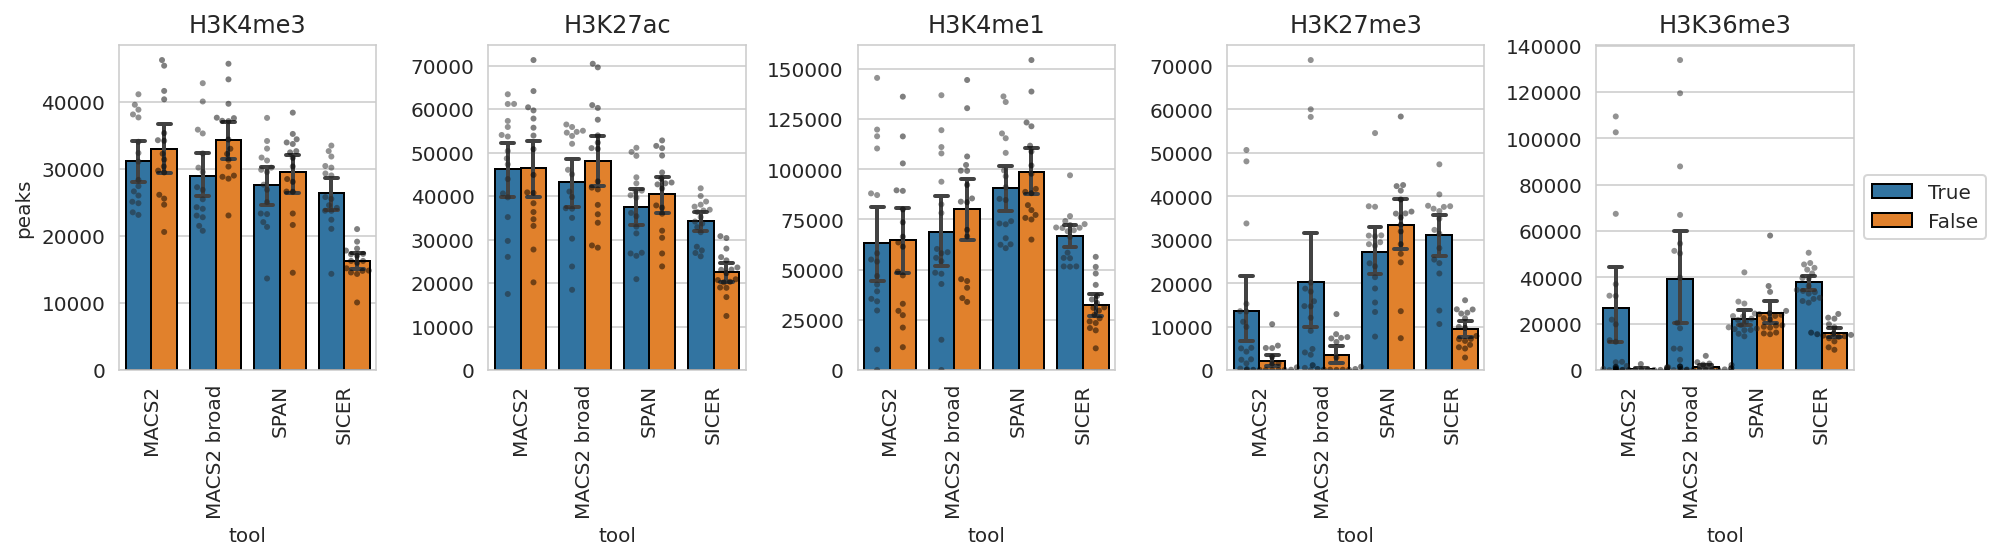

Roadmap


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette usin

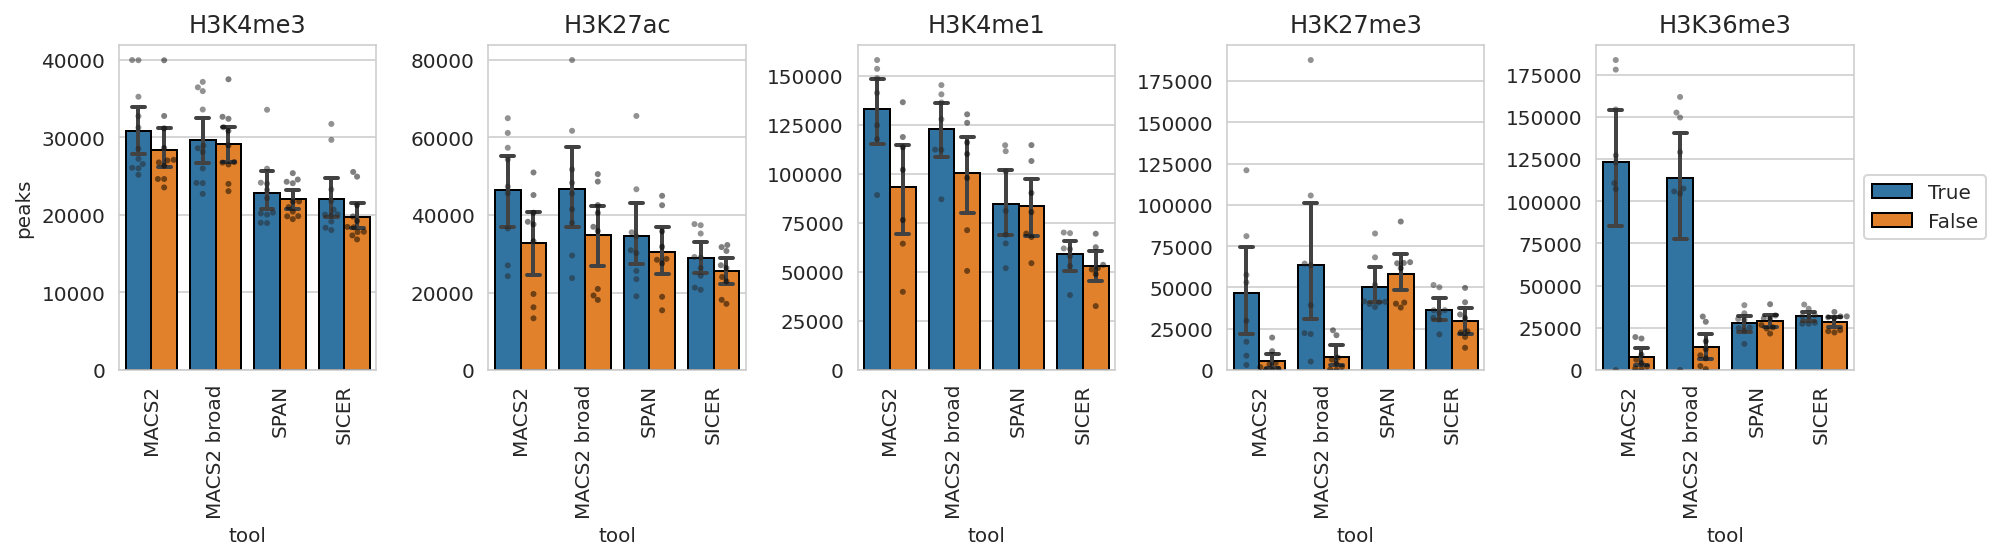

In [79]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(14, 4))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        sns.barplot(data=df_peaks[(df_peaks['dataset'] == ds) & 
                                  (df_peaks['modification'] == m)], x='tool', y='peaks', hue='control',
                    capsize=.2, errwidth=2, edgecolor="black",
                    order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                    hue_order=[True, False],
                    ax=ax,)
        sns.swarmplot(data=df_peaks[(df_peaks['dataset'] == ds) &
                                    (df_peaks['modification'] == m)], x='tool', y='peaks', hue='control',
                      dodge=True, size=3, color="black", alpha=0.5,
                      order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
                      hue_order=[True, False],
                      ax=ax)

        ax.xaxis.set_tick_params(rotation=90)
        ax.title.set_text(m)
        if i > 0:
            ax.set_ylabel(None)
        else:
            ax.set_ylabel('peaks')
        if i < 4:
            ax.legend().set_visible(False)
        else:
            # Put a legend to the right of the current axis
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # ax.set_ylim(0, 1.9e7)
    plt.tight_layout()
    # plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
    plt.show()

# Compute ratio no control vs control

In [41]:
rows = []
for (ds, m, c, r, t), dft in tqdm(df_peaks.groupby(['dataset', 'modification', 'cell', 'replicate', 'tool'])):
    if len(dft) == 2:
        with_control = dft[dft['control'] == True]['file'].values[0]
        without_control = dft[dft['control'] == False]['file'].values[0]
        peaks_with_control = lines(with_control)
        peaks_without_control = lines(without_control)
        rows.append((ds, m, c, r, t, d(peaks_without_control, peaks_with_control)))
df_ratio = pd.DataFrame(rows, columns=['dataset', 'modification', 'cell', 'replicate', 'tool', 'ratio'])
df_ratio['ratio'] = ((df_ratio['ratio'] - 1) * 100).astype(int)
del rows
df_ratio.sample(3)

  0%|          | 0/504 [00:00<?, ?it/s]

dataset modification    cell replicate         tool  ratio
481  Roadmap      H3K4me3  CD4ABT      rep2  MACS2 broad    -20
147   ENCODE     H3K36me3      H1      rep2         SPAN      9
33    ENCODE      H3K27ac   HepG2      rep2  MACS2 broad     42

ENCODE


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


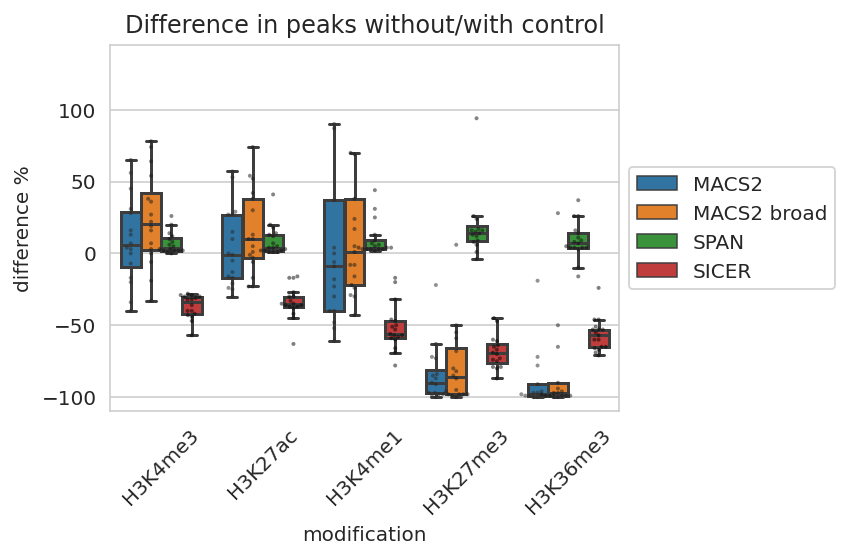

Roadmap


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


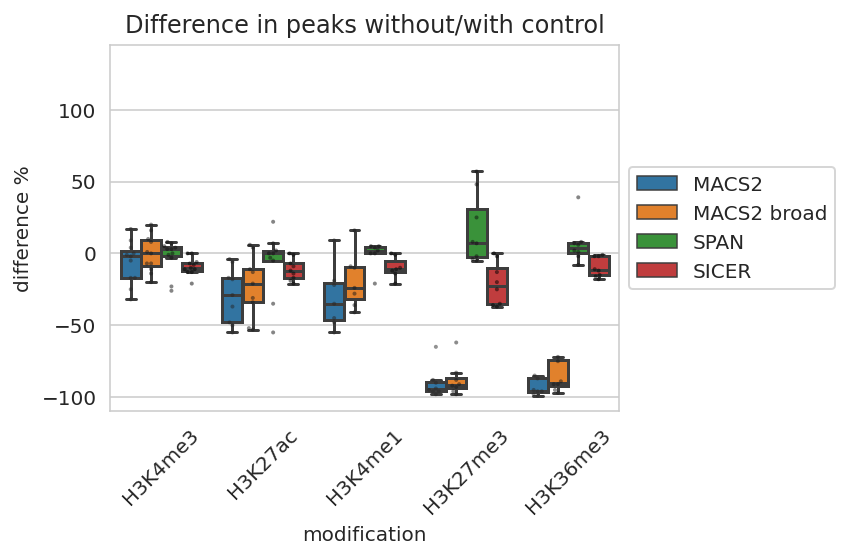

In [42]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(6, 4))
    ax = plt.axes()
    sns.boxplot(data=df_ratio[df_ratio['dataset'] == ds],
                x='modification', y='ratio', hue='tool',
                showfliers=False,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
                hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                ax=ax)
    sns.swarmplot(data=df_ratio[df_ratio['dataset'] == ds],
                  x='modification', y='ratio', hue='tool',
                  dodge=True, size=2, color="black", alpha=0.5,
                  order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
                  hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
                  ax=ax)    
    ax.set_ylabel('difference %')
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_ylim(-110, 145)
    ax.set_title('Difference in peaks without/with control')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

# Jaccard without control vs with control

In [12]:
tf = tempfile.mktemp()
rows = []
for (ds, m, c, r, t), dft in tqdm(df_peaks.groupby(['dataset', 'modification', 'cell', 'replicate', 'tool'])):
    if len(dft) == 2:
        with_control = sorted_file(dft[dft['control'] == True]['file'].values[0])
        without_control = sorted_file(dft[dft['control'] == False]['file'].values[0])
        peaks_with_control = lines(with_control)
        peaks_without_control = lines(without_control)
        len_with_control = bedl(with_control).sum()
        len_without_control = bedl(without_control).sum()
        !bedtools intersect -a {with_control} -b {without_control} -wo > {tf}
        overlap_len = int(last_col(tf).sum())
        jaccard = d(overlap_len, len_with_control + len_without_control - overlap_len)
        rows.append((ds, m, c, r, t, peaks_with_control, peaks_without_control, len_with_control, len_without_control, 
                     d(len_with_control, peaks_with_control), d(len_without_control, peaks_without_control),
                     overlap_len, jaccard))
df_jaccard = pd.DataFrame(rows, columns=['dataset', 'modification', 'cell', 'replicate', 'tool',
                                         'peaks_with_control', 'peaks_without_control',
                                         'len_with_control', 'len_without_control', 
                                         'avg_len_with_control', 'avg_len_without_control',
                                         'overlap_len', 'jaccard'])
del rows
df_jaccard.sample(3)

  0%|          | 0/504 [00:00<?, ?it/s]

dataset modification   cell replicate         tool  peaks_with_control  \
217   ENCODE      H3K4me1   HMEC      rep1  MACS2 broad               15099   
375  Roadmap     H3K27me3   CD34                   SPAN               39818   
31    ENCODE      H3K27ac  HepG2      rep1         SPAN               26891   

     peaks_without_control  len_with_control  len_without_control  \
217                 106327         7524484.0             63932875   
375                  37855       269803240.0            295547784   
31                   30419        71976709.0             85886479   

     avg_len_with_control  avg_len_without_control  overlap_len   jaccard  
217            498.343202               601.285421      6802608  0.105214  
375           6775.911397              7807.364523    263451156  0.872644  
31            2676.609609              2823.448470     71828906  0.834887

ENCODE


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


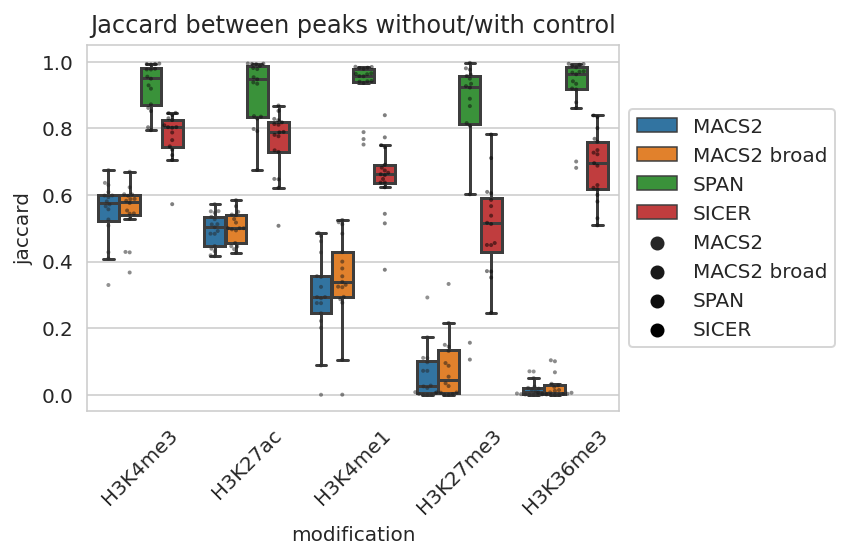

Roadmap


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


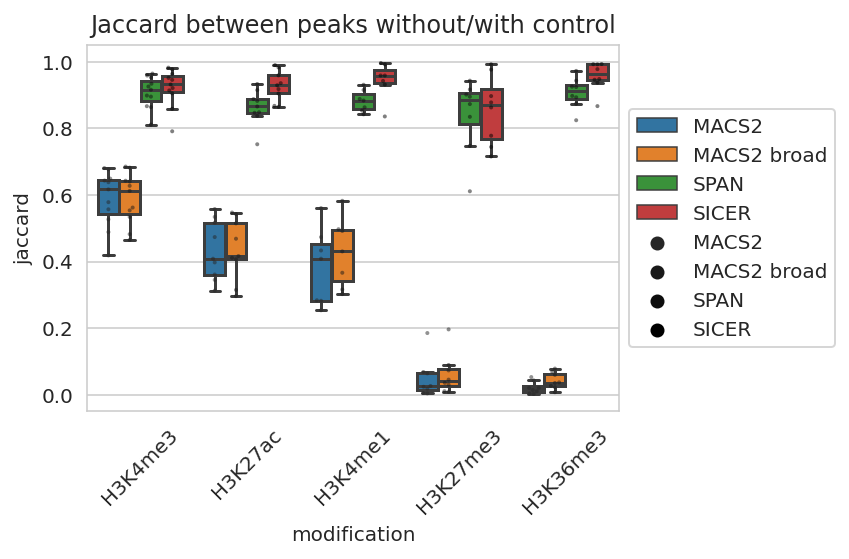

In [30]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(6, 4))
    ax = plt.axes()
    sns.boxplot(data=df_jaccard[df_jaccard['dataset'] == ds],
                x='modification', y='jaccard', hue='tool',
                showfliers=False,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
                hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                ax=ax)
    sns.swarmplot(data=df_jaccard[df_jaccard['dataset'] == ds],
                  x='modification', y='jaccard', hue='tool',
                  dodge=True, size=2, color="black", alpha=0.5,
                  order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
                  hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
                  ax=ax)
    ax.set_ylabel('jaccard')
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_ylim(-0.05, 1.05)
    ax.set_title('Jaccard between peaks without/with control')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

In [31]:
df_jaccard[(df_jaccard['dataset'] == 'Roadmap') & 
         (df_jaccard['modification'] == 'H3K27me3') & 
         (df_jaccard['jaccard'] < 0.2)]

dataset modification      cell replicate         tool  \
368  Roadmap     H3K27me3     BCell                  MACS2   
369  Roadmap     H3K27me3     BCell            MACS2 broad   
372  Roadmap     H3K27me3      CD34                  MACS2   
373  Roadmap     H3K27me3      CD34            MACS2 broad   
376  Roadmap     H3K27me3      CD34      rep2        MACS2   
377  Roadmap     H3K27me3      CD34      rep2  MACS2 broad   
380  Roadmap     H3K27me3       CD4                  MACS2   
381  Roadmap     H3K27me3       CD4            MACS2 broad   
384  Roadmap     H3K27me3       CD4      rep2        MACS2   
385  Roadmap     H3K27me3       CD4      rep2  MACS2 broad   
388  Roadmap     H3K27me3  Monocyte                  MACS2   
389  Roadmap     H3K27me3  Monocyte            MACS2 broad   
392  Roadmap     H3K27me3        NK                  MACS2   
393  Roadmap     H3K27me3        NK            MACS2 broad   
396  Roadmap     H3K27me3      PBMC                  MACS2   
397  Roadmap     H3K27me3      PBMC            MACS2 broad   

     peaks_with_control  peaks_without_control  len_with_control  \
368              120947                  11481        62817094.0   
369              187656                  21098       115946312.0   
372               53084                   1819        29118068.0   
373               64451                   3891        45059059.0   
376               81061                   4321        70038383.0   
377              105668                   7535       105504627.0   
380                3126                    113         1004365.0   
381                5166                    179         2053450.0   
384                8738                    148         3386228.0   
385               21849                    387         9943058.0   
388               57580                  19683        57137110.0   
389               63468                  24114        73399321.0   
392               29830                   3425        17394449.0   
393               39266                   6388        27560261.0   
396               17158                    771         8684813.0   
397               22388                   1989        16014841.0   

     len_without_control  avg_len_with_control  avg_len_without_control  \
368              4307222            519.377033               375.160874   
369              8882313            617.866266               421.002607   
372               594207            548.528144               326.666850   
373              1455076            699.121177               373.959393   
376              1913425            864.020713               442.819949   
377              3847627            998.453903               510.633975   
380                43409            321.293986               384.150442   
381                71059            397.493225               396.977654   
384                60751            387.528954               410.479730   
385               155111            455.080690               400.803618   
388             11086611            992.308267               563.258192   
389             15376599           1156.477611               637.662727   
392              1393025            583.119309               406.722628   
393              2938642            701.886136               460.025360   
396               280481            506.166978               363.788586   
397               854130            715.331472               429.426848   

     overlap_len   jaccard    union_len  overlap_diff  
368      4064940  0.064462   63059376.0    58994436.0  
369      8526993  0.073318  116301632.0   107774639.0  
372       545712  0.018710   29166563.0    28620851.0  
373      1383724  0.030661   45130411.0    43746687.0  
376      1868617  0.026663   70083191.0    68214574.0  
377      3792270  0.035925  105559984.0   101767714.0  
380         4627  0.004436    1043147.0     1038520.0  
381        23183  0.011033    2101326.0     2078143.0  
384        18

In [15]:
df_jaccard['union_len'] = df_jaccard['len_with_control'] + df_jaccard['len_without_control']  - df_jaccard['overlap_len']
df_jaccard['overlap_diff'] = df_jaccard['len_with_control'] + df_jaccard['len_without_control']  - 2 * df_jaccard['overlap_len']

ENCODE


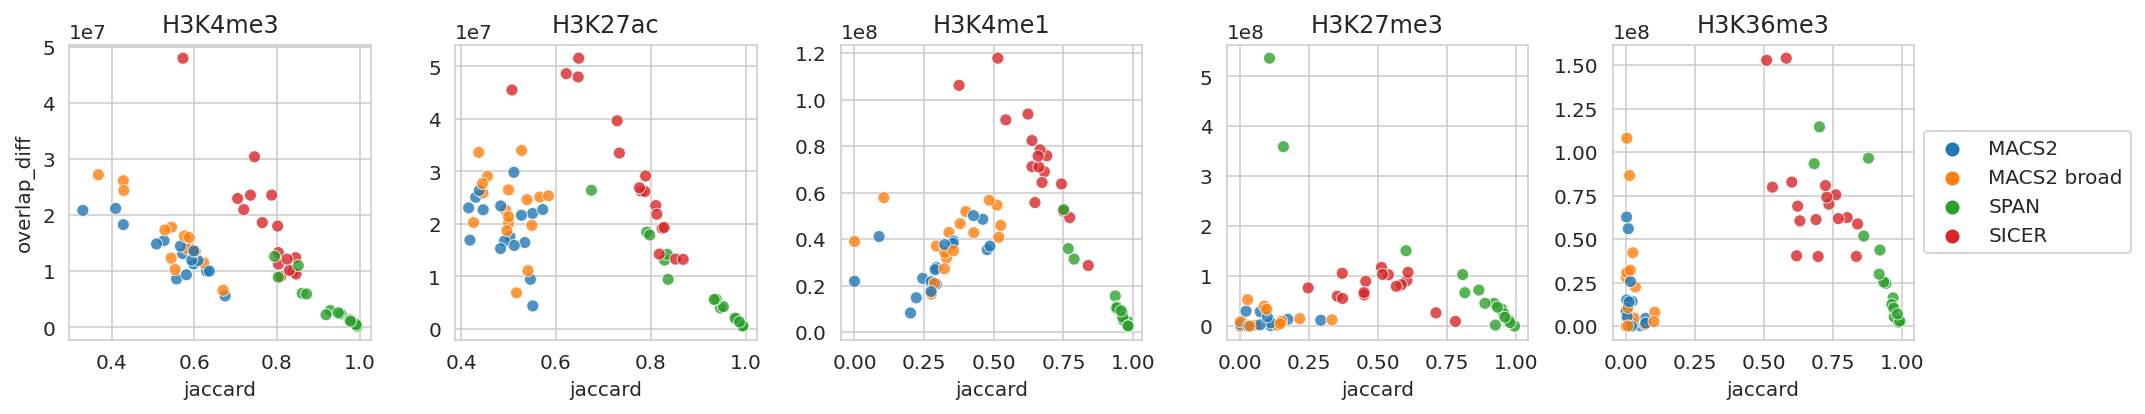

Roadmap


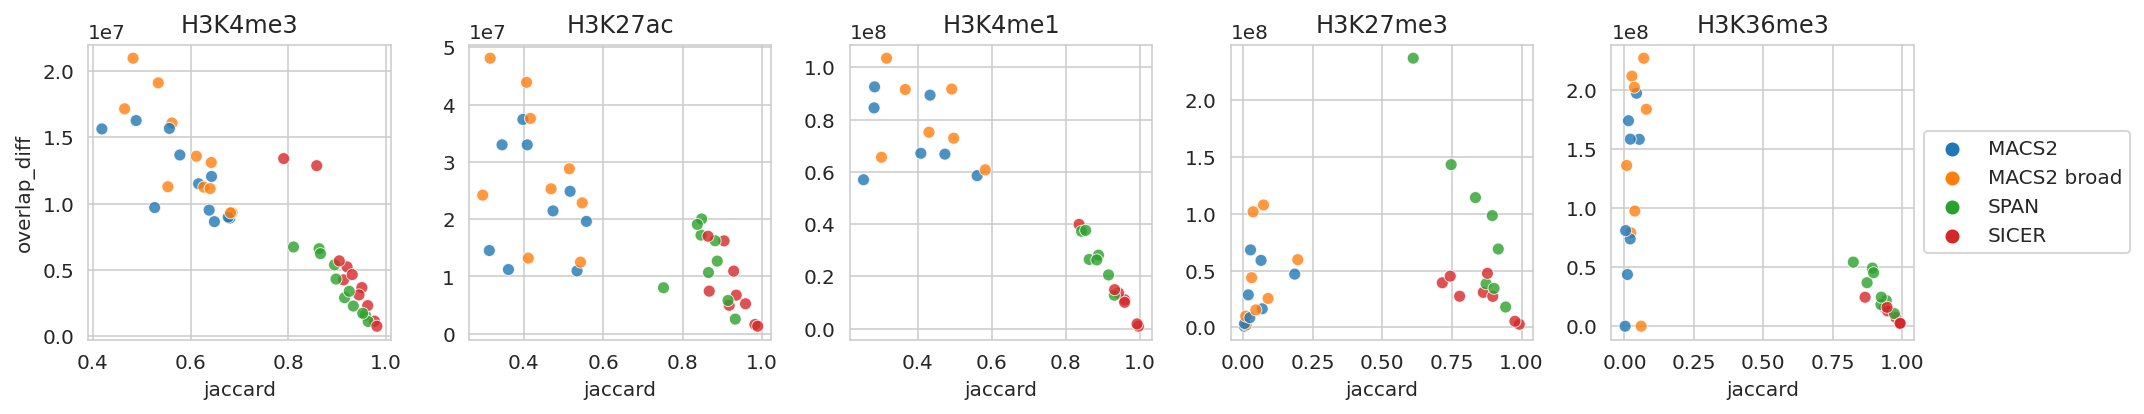

In [16]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(15, 3))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        sns.scatterplot(df_jaccard[(df_jaccard['dataset'] == ds) &
                                   (df_jaccard['modification'] == m)],
                        palette=TOOLS_PALETTE,
                        hue_order=TOOLS,
                        x='jaccard', y='overlap_diff', hue='tool', alpha=0.8,
                        ax = ax)
        ax.set_title(m)
        if i > 0:
            ax.set_ylabel(None)
        if i < len(axs) - 1:
            ax.legend().set_visible(False)
        else:
            # Put a legend to the right of the current axis
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

In [17]:
rows = []
for _, (ds, modification, tool, jaccard, avlc, avlwc) in df_jaccard[
    ['dataset', 'modification', 'tool', 'jaccard', 'avg_len_with_control', 'avg_len_without_control']].iterrows():
    rows.append((ds, modification, tool, jaccard, avlc))
    rows.append((ds, modification, tool, jaccard, avlwc))
df_jaccard_avg_len = pd.DataFrame(rows, columns=['dataset', 'modification', 'tool', 'jaccard', 'average_len'])
del rows

ENCODE


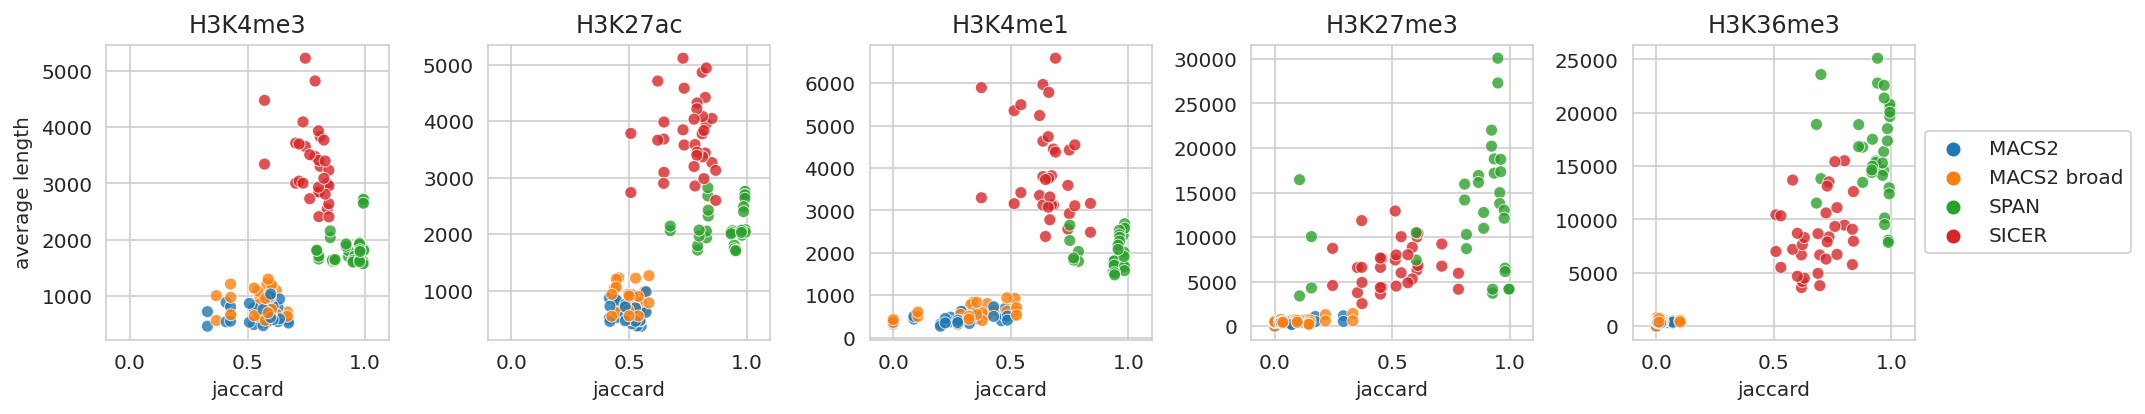

Roadmap


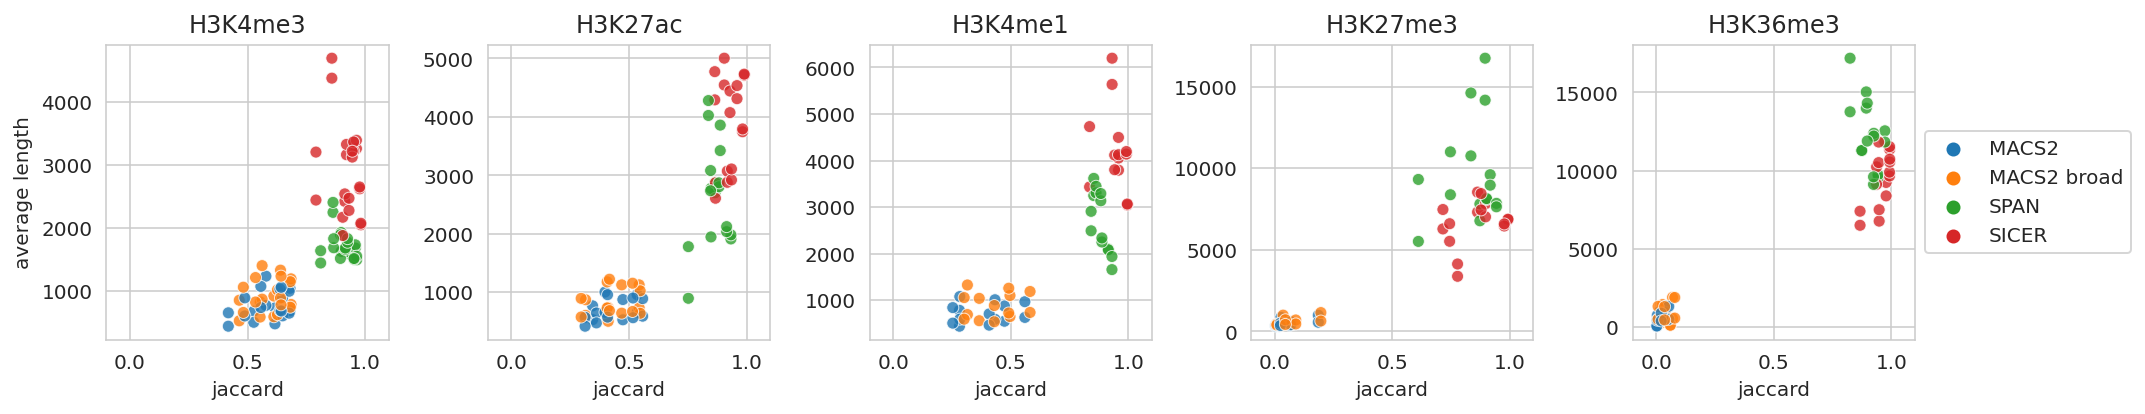

In [18]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(15, 3))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        sns.scatterplot(
            df_jaccard_avg_len[(df_jaccard_avg_len['dataset'] == ds) &
                       (df_jaccard_avg_len['modification'] == m)],
            palette=TOOLS_PALETTE,
            hue_order=TOOLS,
            x='jaccard', y='average_len', hue='tool', alpha=0.8,
            ax = ax,
            # fill=True
        )
        ax.set_title(m)
        ax.set_xlim(-0.1, 1.1)
        ax.set_title(m)
        if i > 0:
            ax.set_ylabel(None)
        else:
            ax.set_ylabel('average length')
        if i < len(axs) - 1:
            ax.legend().set_visible(False)
        else:
            # Put a legend to the right of the current axis
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

In [19]:
# K27me3 outliers HepG2 rep1 and HMEC rep2
df_jaccard[(df_jaccard['dataset'] == 'ENCODE') & (df_jaccard['modification'] == 'H3K27me3') & (df_jaccard['tool']=='SPAN')]

dataset modification     cell replicate  tool  peaks_with_control  \
71   ENCODE     H3K27me3  GM12878      rep2  SPAN               21369   
75   ENCODE     H3K27me3       H1      rep1  SPAN                7709   
79   ENCODE     H3K27me3       H1      rep2  SPAN               13353   
83   ENCODE     H3K27me3     HMEC      rep1  SPAN               37477   
87   ENCODE     H3K27me3     HMEC      rep2  SPAN               15523   
91   ENCODE     H3K27me3     HSMM      rep1  SPAN               28948   
95   ENCODE     H3K27me3     HSMM      rep2  SPAN               37548   
99   ENCODE     H3K27me3    HepG2      rep1  SPAN               18708   
103  ENCODE     H3K27me3    HepG2      rep2  SPAN               24559   
107  ENCODE     H3K27me3    Huvec      rep1  SPAN               30740   
111  ENCODE     H3K27me3    Huvec      rep2  SPAN               54011   
115  ENCODE     H3K27me3     K562      rep1  SPAN               29385   
119  ENCODE     H3K27me3     K562      rep2  SPAN               28578   
123  ENCODE     H3K27me3     NHEK      rep1  SPAN               30872   
127  ENCODE     H3K27me3     NHEK      rep2  SPAN               30964   
131  ENCODE     H3K27me3     NHLF      rep1  SPAN               23845   

     peaks_without_control  len_with_control  len_without_control  \
71                   24811       642764451.0            677327897   
75                    7344        28551394.0             30491881   
79                   13566        56156586.0             56325887   
83                   42603       561587037.0            586501043   
87                   42359        66602944.0            425836883   
91                   36027       461666065.0            510340318   
95                   41319       488880872.0            500583596   
99                   36494        63500509.0            600018917   
103                  28991       540437196.0            585929846   
107                  35152       392295491.0            386264144   
111                  58380       352070683.0            358222736   
115                  31937       497167593.0            515230982   
119                  33463       536586673.0            574714159   
123                  36071       229080204.0            378854673   
127                  39286       318865719.0            341874392   
131                  26780       446505257.0            464370423   

     avg_len_with_control  avg_len_without_control  overlap_len   jaccard  \
71           30079.294820             27299.500101    642764301  0.948970   
75            3703.644312              4151.944581     28396259  0.926559   
79            4205.540777              4151.989312     56137494  0.996318   
83           14984.845025             13766.660634    561418133  0.956957   
87            4290.597436             10053.043816     66592621  0.156377   
91           15948.116105             14165.495823    434307172  0.807714   
95           13020.157452             12115.094654    488712853  0.975959   
99            3394.297039             16441.577163     63499906  0.105830   
103          22005.667820             20210.749750    540373590  0.922150   
107          12761.727098             10988.397360    366324962  0.888632   
111           6518.499620              6136.052347    351550385  0.979950   
115          16919.094538             16132.729499    470014723  0.866572   
119          18776.215026             17174.615516    536585802  0.933655   
123           7420.322752             10503.026614    228415813  0.601856   
127          10297.949845              8702.193962    296802750  0.815533   
131          18725.320067             17340.195034    446439584  0.961251   

       union_len  overlap_diff  
71   677328047.0    34563746.0  
75    30647016.0     2250757.0  
79    56344979.0      207485.0  
83   586669947.0    25251814.0  
87   425847206.0   359254585.0  
91   537699211.0   103392039.0  
95   500751615.0    12038762.0  
99   600019520

In [20]:
# for ds, m in product(['ENCODE', 'Roadmap'], ['H3K4me3', 'H3K36me3']):
#     print(ds, m)
#     plt.figure(figsize=(5, 3))
#     ax = plt.axes()
#     # sns.kdeplot(
#         
#     sns.scatterplot(
#         df_jaccard[(df_jaccard['dataset'] == ds) &
#                                (df_jaccard['modification'] == m)],
#                     palette=TOOLS_PALETTE,
#                     hue_order=TOOLS,
#                     x='jaccard', y='avg_len_with_control', hue='tool', alpha=0.8,
#                     ax = ax,
#     # fill=True
#     )
#     ax.set_title(m)
#     ax.set_xlim(-0.1, 1.1)
#     ax.set_ylabel('average length')
#     # Put a legend to the right of the current axis
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.tight_layout()
#     plt.show()

In [21]:
# for ds, m in product(['ENCODE', 'Roadmap'], ['H3K4me3', 'H3K36me3']):
#     print(ds, m)
#     plt.figure(figsize=(5, 3))
#     ax = plt.axes()
#     sns.scatterplot(df_jaccard[(df_jaccard['dataset'] == ds) &
#                                (df_jaccard['modification'] == m)],
#                     palette=TOOLS_PALETTE,
#                     hue_order=TOOLS,
#                     x='avg_len_with_control', y='avg_len_without_control', hue='tool', alpha=0.8,
#                     ax = ax)
#     ax.set_title(m)
#     # Put a legend to the right of the current axis
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.tight_layout()
#     plt.show()

# Load BAMS

In [116]:
def load_bams(path, modifications, cells, replicates, control='Input'):
    df_bams = pd.DataFrame(columns=['bam_file', 'modification', 'cell', 'replicate', 'reads'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith('.bam'):
            continue
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        mod = next((m for m in modifications if m in f), None)
        if mod is None and control is not None and control in f:
            mod = 'Control'
        if cell and mod and rep is not None:
            file = os.path.join(path, f)
            reads = ! samtools view -F 0x04 -c {file}
            reads = int(reads[0])
            df_bams.loc[len(df_bams)] = (file, mod, cell, rep, reads)
    return df_bams

In [117]:
df_encode_bams = load_bams(GSE26320_PATH + '/bams', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
df_encode_bams['dataset'] = 'ENCODE'
df_immune_bams = load_bams(IMMUNE_PATH + '/bams', MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS, 'Control')
df_immune_bams['dataset'] = 'Roadmap'

df_bams = pd.concat([df_encode_bams, df_immune_bams]).reset_index(drop=True)


  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

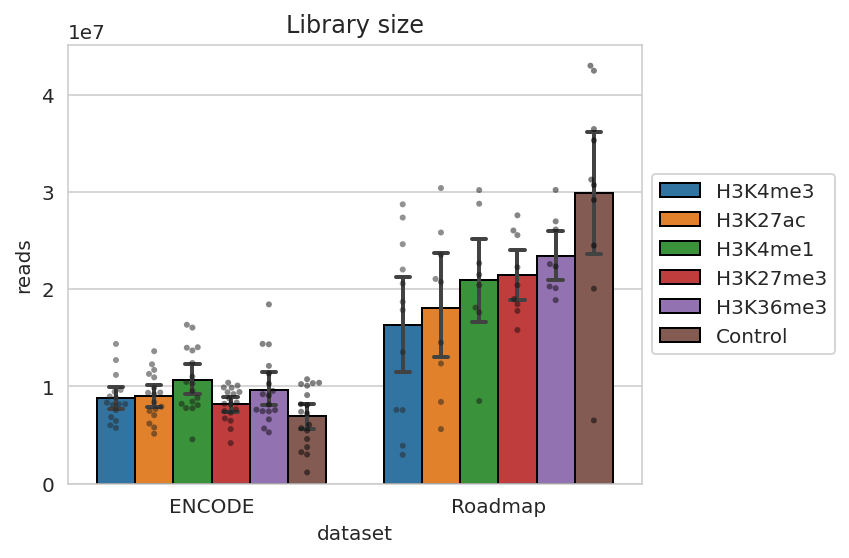

In [121]:
plt.figure(figsize=(6, 4))
ax = plt.axes()
sns.barplot(data=df_bams, hue='modification', x='dataset', y='reads',
            capsize=.05, errwidth=2, edgecolor="black",
            order=['ENCODE', 'Roadmap'],
            hue_order=MODIFICATIONS + ['Control'],
            ax=ax)
sns.swarmplot(data=df_bams, hue='modification', x='dataset', y='reads',
              dodge=True, size=3, palette='dark:black', alpha=0.5, legend=False,
              order=['ENCODE', 'Roadmap'],
              hue_order=MODIFICATIONS + ['Control'],
              ax=ax)
ax.set_title('Library size')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [283]:
rows = []
for (ds, m, c), group in tqdm(
        df_bams[(df_bams['modification'] != 'Control')].groupby(['dataset', 'modification', 'cell'])):
    if len(group) != 2:
        continue
    file1, file2 = group['bam_file'].values[0], group['bam_file'].values[1]
    r1, r2 = group['replicate'].values[0], group['replicate'].values[1]
    cr1 = r1
    # Find control1
    ct = df_bams[(df_bams['modification'] == 'Control') & (df_bams['cell'] == c) &
                 (df_bams['replicate'] == cr1) & (df_bams['dataset'] == ds)]
    if len(ct) == 0:  # Control can be different for Roadmap
        cr1 = ''
        ct = df_bams[(df_bams['modification'] == 'Control') & (df_bams['cell'] == c) &
                     (df_bams['replicate'] == cr1) & (df_bams['dataset'] == ds)]
    if len(ct) == 0:
        continue
    control1 = ct['bam_file'].values[0]
    # Find control1
    cr2 = r2
    ct = df_bams[(df_bams['modification'] == 'Control') & (df_bams['cell'] == c) &
                 (df_bams['replicate'] == cr2) & (df_bams['dataset'] == ds)]
    if len(ct) == 0:  # Control can be different for Roadmap
        cr2 = ''
        ct = df_bams[(df_bams['modification'] == 'Control') & (df_bams['cell'] == c) &
                     (df_bams['replicate'] == cr2) & (df_bams['dataset'] == ds)]
    if len(ct) == 0:
        continue
    control2 = ct['bam_file'].values[0]
    if control1 == control2:
        continue  # Ignore same control for replicates
    rows.append((ds, m, c, r1, file1, cr1, control1, r2, file2, cr2, control2))
df_controls = pd.DataFrame(rows, columns=['dataset', 'modification', 'cell',
                                          'replicate1', 'file1', 'control_replicate1', 'control_file1',
                                          'replicate2', 'file2', 'control_replicate2', 'control_file2'])
df_controls.sample(5)

  0%|          | 0/80 [00:00<?, ?it/s]

dataset modification     cell replicate1  \
27  ENCODE      H3K4me1     HMEC       rep1   
0   ENCODE      H3K27ac  GM12878       rep2   
13  ENCODE     H3K27me3    Huvec       rep2   
19  ENCODE     H3K36me3     HMEC       rep2   
29  ENCODE      H3K4me1    Huvec       rep2   

                                                file1 control_replicate1  \
27  /home/jetbrains/data/2023_GSE26320/bams/GSM646...               rep1   
0   /home/jetbrains/data/2023_GSE26320/bams/GSM646...               rep2   
13  /home/jetbrains/data/2023_GSE26320/bams/GSM646...               rep2   
19  /home/jetbrains/data/2023_GSE26320/bams/GSM646...               rep2   
29  /home/jetbrains/data/2023_GSE26320/bams/GSM646...               rep2   

                                        control_file1 replicate2  \
27  /home/jetbrains/data/2023_GSE26320/bams/GSM646...       rep2   
0   /home/jetbrains/data/2023_GSE26320/bams/GSM646...       rep1   
13  /home/jetbrains/data/2023_GSE26320/bams/GSM646...       rep1   
19  /home/jetbrains/data/2023_GSE26320/bams/GSM646...       rep1   
29  /home/jetbrains/data/2023_GSE26320/bams/GSM646...       rep1   

                                                file2 control_replicate2  \
27  /home/jetbrains/data/2023_GSE26320/bams/GSM646...               rep2   
0   /home/jetbrains/data/2023_GSE26320/bams/GSM646...               rep1   
13  /home/jetbrains/data/2023_GSE26320/bams/GSM646...               rep1   
19  /home/jetbrains/data/2023_GSE26320/bams/GSM646...               rep1   
29  /home/jetbrains/data/2023_GSE26320/bams/GSM646...               rep1   

                                        control_file2  
27  /home/jetbrains/data/2023_GSE26320/bams/GSM646...  
0   /home/jetbrains/data/2023_GSE26320/bams/GSM646...  
13  /home/jetbrains/data/2023_GSE26320/bams/GSM646...  
19  /home/jetbrains/data/2023_GSE26320/bams/GSM646...  
29  /home/jetbrains/data/2023_GSE26320/bams/GSM646...

In [365]:
t = pd.merge(df_controls, df_peaks[(df_peaks['control']==True)][['dataset', 'modification', 'cell', 'replicate', 'tool', 'peaks']], 
             left_on=['dataset', 'modification', 'cell', 'replicate1'],
             right_on=['dataset', 'modification', 'cell', 'replicate']
             )
t.rename({'peaks': 'rep1_peaks'}, axis=1, inplace=True)
t.drop('replicate', axis=1, inplace=True)
t = pd.merge(t, df_peaks[df_peaks['control']==True][['dataset', 'modification', 'cell', 'replicate', 'tool', 'peaks']],
             left_on=['dataset', 'modification', 'cell', 'tool', 'replicate2'],
             right_on=['dataset', 'modification', 'cell', 'tool', 'replicate']
             )
t.rename({'peaks': 'rep2_peaks'}, axis=1, inplace=True)
t.drop('replicate', axis=1, inplace=True)
t = pd.merge(t, df_bams[['dataset', 'modification', 'cell', 'replicate', 'reads']],
             left_on=['dataset', 'modification', 'cell', 'replicate1'],
             right_on=['dataset', 'modification', 'cell', 'replicate']
             )
t.rename({'reads': 'rep1_reads'}, axis=1, inplace=True)
t.drop('replicate', axis=1, inplace=True)
t = pd.merge(t, df_bams[['dataset', 'modification', 'cell', 'replicate', 'reads']],
             left_on=['dataset', 'modification', 'cell', 'replicate2'],
             right_on=['dataset', 'modification', 'cell', 'replicate']
             )
t.rename({'reads': 'rep2_reads'}, axis=1, inplace=True)
t.drop('replicate', axis=1, inplace=True)
t = pd.merge(t, df_bams[df_bams['modification'] == 'Control'][['dataset', 'cell', 'replicate', 'reads']], 
             left_on=['dataset', 'cell', 'control_replicate1'],
             right_on=['dataset', 'cell', 'replicate']
             )
t.rename({'reads': 'rep1_ctrl_reads'}, axis=1, inplace=True)
t.drop('replicate', axis=1, inplace=True)
t = pd.merge(t, df_bams[df_bams['modification'] == 'Control'][['dataset', 'cell', 'replicate', 'reads']],
             left_on=['dataset', 'cell', 'control_replicate2'],
             right_on=['dataset', 'cell', 'replicate']
             )
t.rename({'reads': 'rep2_ctrl_reads'}, axis=1, inplace=True)
t.drop('replicate', axis=1, inplace=True)

t.head(5)

dataset modification     cell replicate1  \
0  ENCODE      H3K27ac  GM12878       rep2   
1  ENCODE      H3K27ac  GM12878       rep2   
2  ENCODE      H3K27ac  GM12878       rep2   
3  ENCODE      H3K27ac  GM12878       rep2   
4  ENCODE      H3K27ac     HMEC       rep1   

                                               file1 control_replicate1  \
0  /home/jetbrains/data/2023_GSE26320/bams/GSM646...               rep2   
1  /home/jetbrains/data/2023_GSE26320/bams/GSM646...               rep2   
2  /home/jetbrains/data/2023_GSE26320/bams/GSM646...               rep2   
3  /home/jetbrains/data/2023_GSE26320/bams/GSM646...               rep2   
4  /home/jetbrains/data/2023_GSE26320/bams/GSM646...               rep1   

                                       control_file1 replicate2  \
0  /home/jetbrains/data/2023_GSE26320/bams/GSM646...       rep1   
1  /home/jetbrains/data/2023_GSE26320/bams/GSM646...       rep1   
2  /home/jetbrains/data/2023_GSE26320/bams/GSM646...       rep1   
3  /home/jetbrains/data/2023_GSE26320/bams/GSM646...       rep1   
4  /home/jetbrains/data/2023_GSE26320/bams/GSM646...       rep2   

                                               file2 control_replicate2  \
0  /home/jetbrains/data/2023_GSE26320/bams/GSM646...               rep1   
1  /home/jetbrains/data/2023_GSE26320/bams/GSM646...               rep1   
2  /home/jetbrains/data/2023_GSE26320/bams/GSM646...               rep1   
3  /home/jetbrains/data/2023_GSE26320/bams/GSM646...               rep1   
4  /home/jetbrains/data/2023_GSE26320/bams/GSM646...               rep2   

                                       control_file2         tool  rep1_peaks  \
0  /home/jetbrains/data/2023_GSE26320/bams/GSM646...        MACS2       43917   
1  /home/jetbrains/data/2023_GSE26320/bams/GSM646...  MACS2 broad       37109   
2  /home/jetbrains/data/2023_GSE26320/bams/GSM646...        SICER       31704   
3  /home/jetbrains/data/2023_GSE26320/bams/GSM646...         SPAN       31429   
4  /home/jetbrains/data/2023_GSE26320/bams/GSM646...        MACS2       40609   

   rep2_peaks  rep1_reads  rep2_reads  rep1_ctrl_reads  rep2_ctrl_reads  
0       47290     5783112     7049058          5469340          5699825  
1       41044     5783112     7049058          5469340          5699825  
2       32861     5783112     7049058          5469340          5699825  
3       35376     5783112     7049058          5469340          5699825  
4       54056    10940745     9860687          3750119         10342115

MACS2


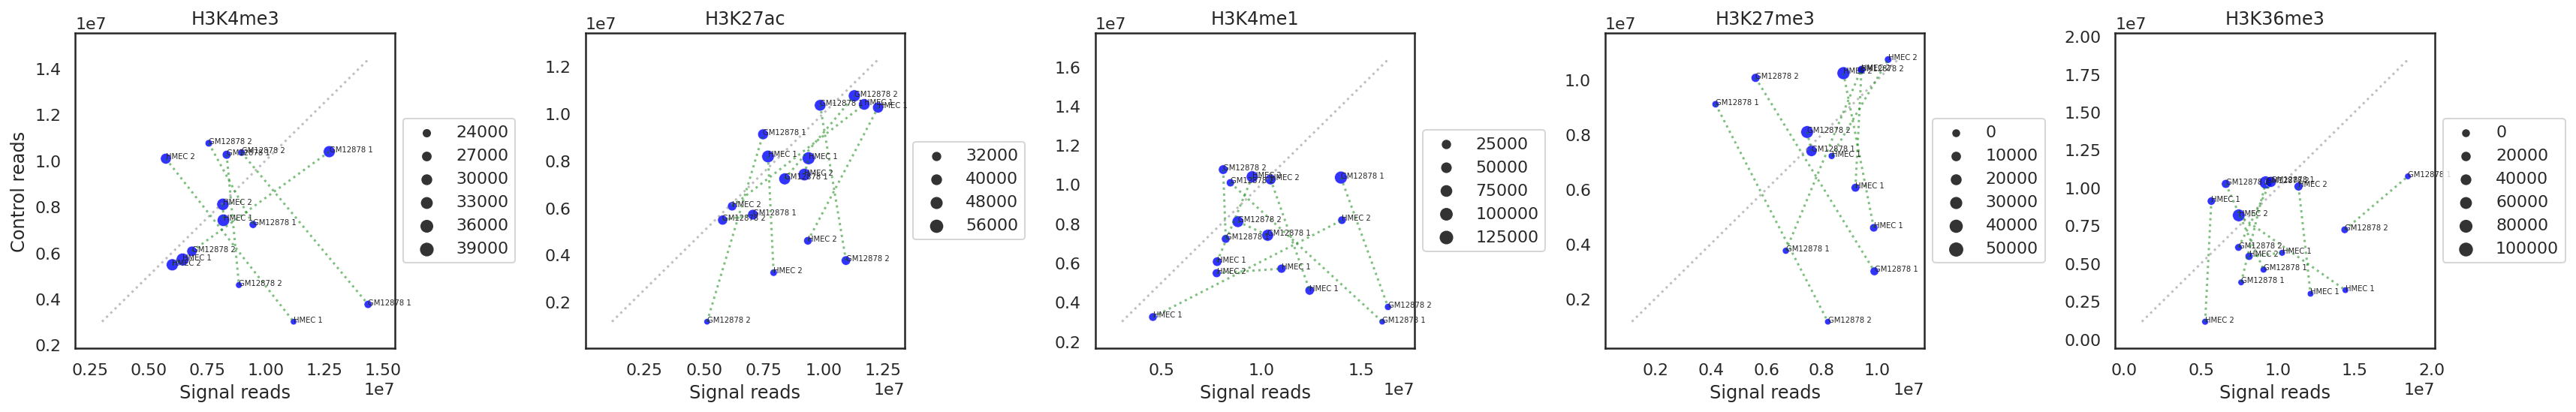

MACS2 broad


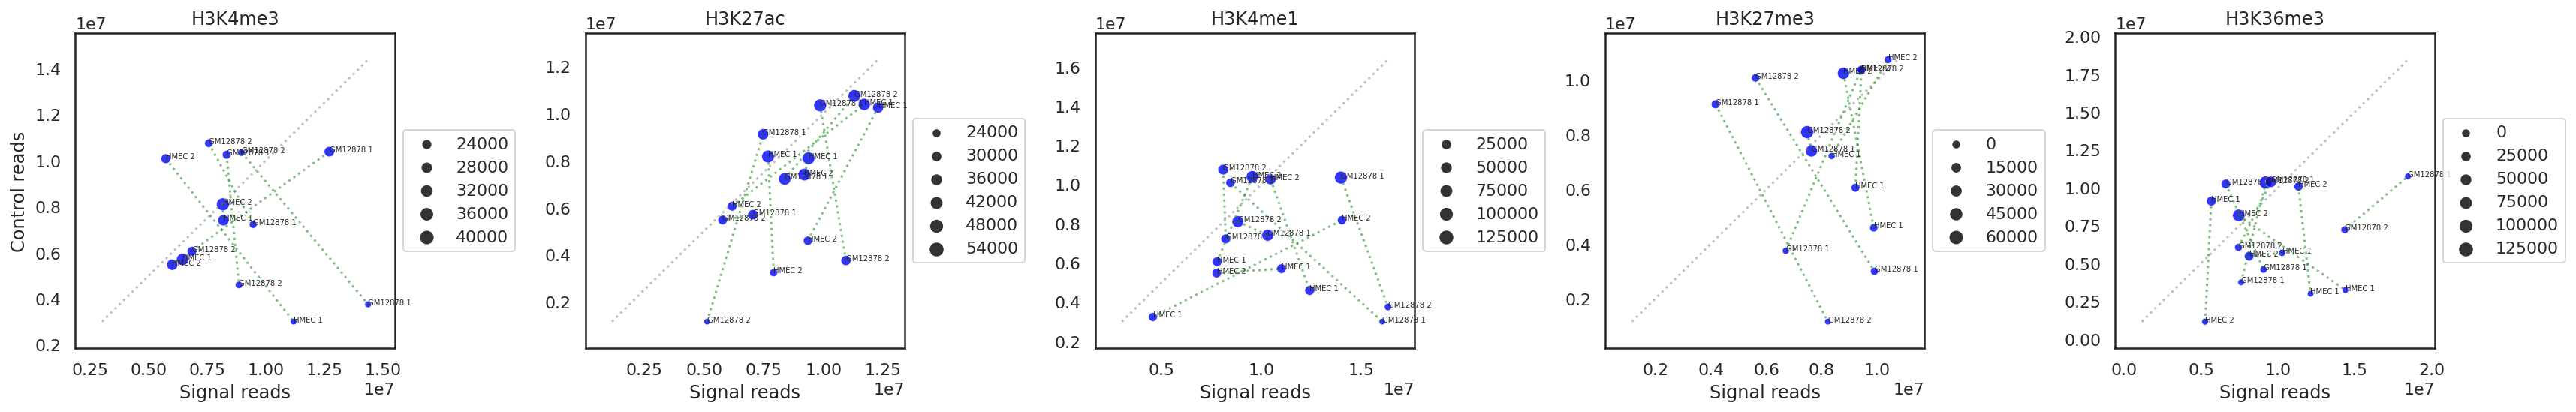

SPAN


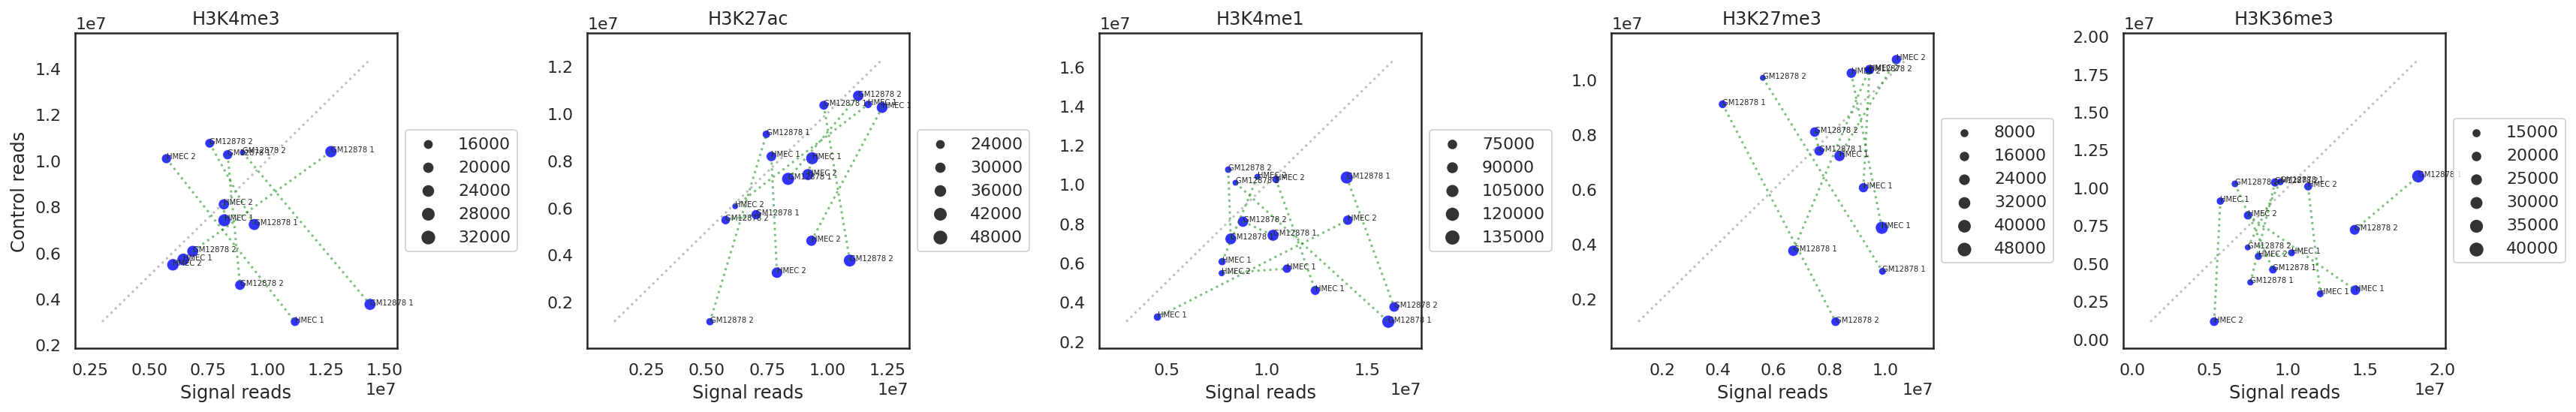

SICER


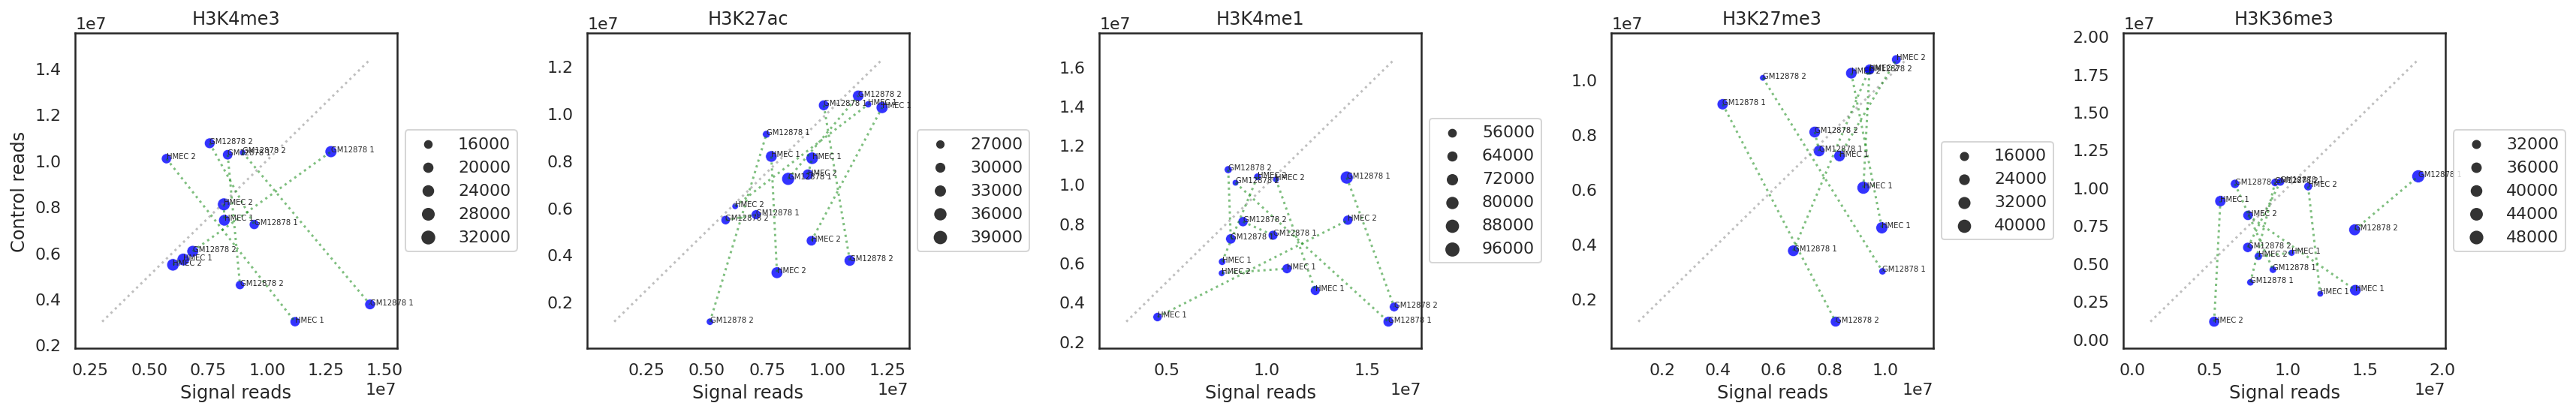

In [366]:
sns.set_theme(style='white')
for tool in TOOLS:
    print(tool)
    plt.figure(figsize=(24, 4))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        ax.set_title(m)
        tt = t[(t['dataset'] == 'ENCODE') & (t['modification'] == m) & (t['tool'] == tool)]
        rep1_peaks, rep1_reads, rep1_ctrl_reads = tt['rep1_peaks'], tt['rep1_reads'], tt['rep1_ctrl_reads'] 
        rep2_peaks, rep2_reads, rep2_ctrl_reads = tt['rep2_peaks'], tt['rep2_reads'], tt['rep2_ctrl_reads']
        minx = min(np.min(rep1_reads), np.min(rep2_reads))
        maxx = max(np.max(rep1_reads), np.max(rep2_reads))
        miny = min(np.min(rep1_ctrl_reads), np.min(rep2_ctrl_reads))
        maxy = max(np.max(rep1_ctrl_reads), np.max(rep2_ctrl_reads))
        minxy = min(minx, miny)
        maxxy = max(maxx, maxy)
        sns.lineplot(x=[minxy, maxxy], y=[minxy, maxxy], color='grey', ax=ax, alpha=0.5, linestyle='dotted')
        sns.scatterplot(x=rep1_reads.to_list() + rep2_reads.to_list(), 
                        y=rep1_ctrl_reads.to_list() + rep2_ctrl_reads.to_list(), 
                        alpha=0.8, ax = ax, 
                        size=rep1_peaks.to_list() + rep2_peaks.to_list(), 
                        color='blue')
        for r1r, r1cr, r2r, r2cr in zip(rep1_reads, rep1_ctrl_reads, rep2_reads, rep2_ctrl_reads):
            sns.lineplot(x=[r1r, r2r], y=[r1cr, r2cr], color='green', ax=ax, alpha=0.5, linestyle='dotted')
        for xv, yv, cell, rep in zip(rep1_reads, rep1_ctrl_reads, t['cell'], t['replicate1']):
            rep = '1' if rep == 'rep1' else '2' if rep == 'rep2' else ''
            ax.text(xv, yv, f'{cell} {rep}', fontsize = 5)
        for xv, yv, cell, rep in zip(rep2_reads, rep2_ctrl_reads, t['cell'], t['replicate2']):
            rep = '1' if rep == 'rep1' else '2' if rep == 'rep2' else ''
            ax.text(xv, yv, f'{cell} {rep}', fontsize = 5)
        offset = 0.1 * (maxxy - minxy)
        ax.set_xlabel('Signal reads')
        ax.set_ylabel('Control reads')
        ax.set_xlim(minxy - offset, maxxy + offset)
        ax.set_ylim(minxy - offset, maxxy + offset)
        if i > 0:
            ax.set_ylabel(None)
        # if i < len(axs) - 1:
        #     ax.legend().set_visible(False)
        # else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()
sns.set_theme(style='whitegrid')

# Compare replicates

In [96]:
def compute_reps_peaks(df_peaks, modifications, cells):
    rows = []
    t = df_peaks[(df_peaks['modification'].isin(modifications)) & (df_peaks['cell'].isin(cells))]
    for (ds, m, c, to), group in t.groupby(['dataset', 'modification', 'cell', 'tool']):
        if len(group) != 2:
            continue
        group.sort_values(by='replicate', inplace=True)
        rep1, rep2 = group['replicate'].values[0], group['replicate'].values[1]
        peaks1, peaks2 = group['peaks'].values[0], group['peaks'].values[1]
        rows.append((ds, m, c, to, rep1, rep2, peaks1, peaks2))
    return pd.DataFrame(rows, columns=['dataset', 'modification', 'cell', 'tool', 'replicate1', 'replicate2', 'peaks1', 'peaks2'])

In [103]:
df_peaks_original = df_peaks[(df_peaks['dataset']=='ENCODE') & (df_peaks['control']==True)].copy()

In [104]:
df_encode_reps = compute_reps_peaks(df_peaks_original, MODIFICATIONS, GSE26320_CELLS)
df_encode_reps.sample(5)

dataset modification  cell   tool replicate1 replicate2  peaks1  peaks2
72   ENCODE     H3K36me3  HSMM  MACS2       rep1       rep2     529   12203
68   ENCODE     H3K36me3  HMEC  MACS2       rep1       rep2       0  109427
119  ENCODE      H3K4me1  NHEK   SPAN       rep1       rep2  108123  117793
42   ENCODE     H3K27me3  HSMM  SICER       rep1       rep2   25434   37162
38   ENCODE     H3K27me3  HMEC  SICER       rep1       rep2   37575   22244

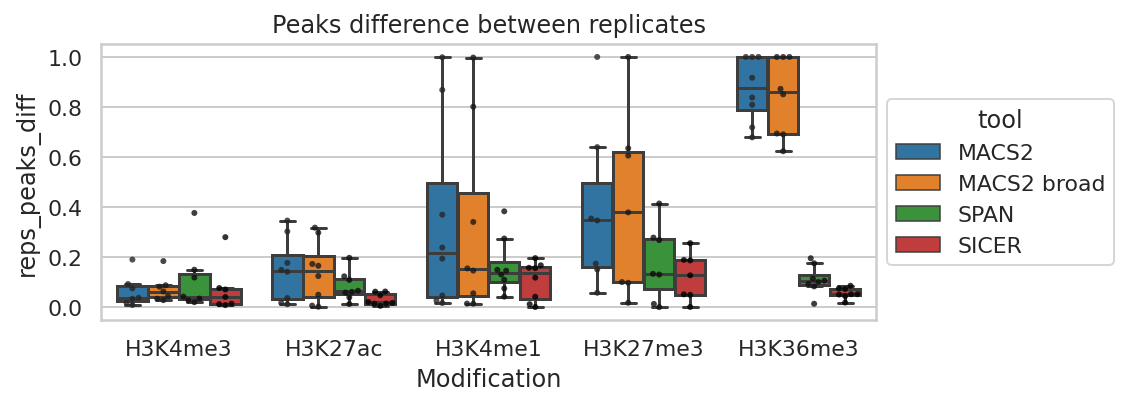

In [380]:
df_encode_reps['reps_peaks_diff'] = np.fabs((df_encode_reps['peaks1'] - df_encode_reps['peaks2']) /
                                            (df_encode_reps['peaks1'] + df_encode_reps['peaks2']))
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=df_encode_reps, x='modification', hue='tool', y='reps_peaks_diff',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=df_encode_reps, x='modification', hue='tool', y='reps_peaks_diff',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.set_title('Peaks difference between replicates')
# ax.set_ylabel('Peaks difference')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# SWAP controls

In [48]:
# Swap controls in replicates
SWAP_CONTROL_DIR = os.path.expanduser('~/data/2024_swap_control')
! mkdir -p {SWAP_CONTROL_DIR}/bams

In [ ]:
for _, (ds, m, c, r1, file1, cr1, control1, r2, file2, cr2, control2) in df_controls[
    ['dataset', 'modification', 'cell',
     'replicate1', 'file1', 'control_replicate1', 'control_file1',
     'replicate2', 'file2', 'control_replicate2', 'control_file2']].iterrows():
    print(ds, m, c)
    print(r1, file1, cr1, control1)
    print(r2, file2, cr2, control2)

    # Keep same signal
    ! ln -sf {file1} {SWAP_CONTROL_DIR}/bams/{ds}_{m}_{c}_{r1}.bam
    ! ln -sf {file2} {SWAP_CONTROL_DIR}/bams/{ds}_{m}_{c}_{r2}.bam
    # Swap controls
    ! ln -sf {control1} {SWAP_CONTROL_DIR}/bams/{ds}_Control_{c}_{r2}_swap.bam
    ! ln -sf {control2} {SWAP_CONTROL_DIR}/bams/{ds}_Control_{c}_{r1}_swap.bam

## Peak calling and visualization

```
conda activate snakemake
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" macs2=True --rerun-trigger mtime;
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1" macs2_suffix="broad0.1"  --rerun-trigger mtime; 
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" span=True sicer=True span_bin=200 span_gap=0 --rerun-trigger mtime; 

```

  0%|          | 0/656 [00:00<?, ?it/s]

MACS2 82


  0%|          | 0/656 [00:00<?, ?it/s]

MACS2 broad 82


  0%|          | 0/82 [00:00<?, ?it/s]

SICER 82


  0%|          | 0/185 [00:00<?, ?it/s]

SPAN 82


/tmp/ipykernel_522188/3518377940.py:15: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df_swapped[df_swapped['modification'] == m], x='tool', y='peaks',
/tmp/ipykernel_522188/3518377940.py:15: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df_swapped[df_swapped['modification'] == m], x='tool', y='peaks',
/tmp/ipykernel_522188/3518377940.py:15: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df_swapped[df_swapped['modification'] == m], x='tool', y='peaks',
/tmp/ipykernel_522188/3518377940.py:15: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df_swapped[df_swapped['modification'] == m], x='tool', y='peaks',
/tmp/ipykernel_522188/3518377940.py:15: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df_swapped[df_swapped['modification'] == m], x='tool', y='peaks',


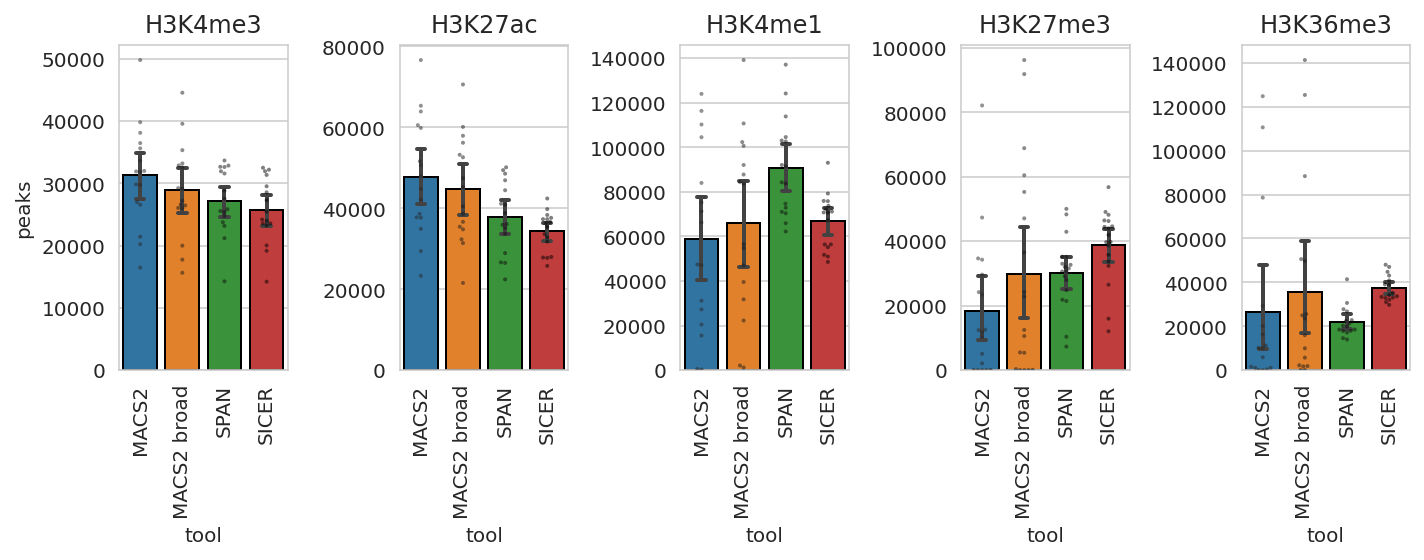

In [82]:
df_swapped = load_peaks_path(SWAP_CONTROL_DIR, MODIFICATIONS, GSE26320_CELLS + IMMUNE_CELLS,
                             GSE26320_REPS + IMMUNE_REPS)
df_swapped['dataset'] = ['ENCODE' if 'ENCODE' in f else 'Roadmap' for f in df_swapped['file']]
df_swapped.sample(5)
plt.figure(figsize=(10, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.barplot(data=df_swapped[df_swapped['modification'] == m], x='tool', y='peaks',
                # showfliers=False,
                capsize=.2, errwidth=2, edgecolor="black",
                palette=TOOLS_PALETTE,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                ax=ax)
    sns.swarmplot(data=df_swapped[df_swapped['modification'] == m], x='tool', y='peaks',
                  size=2, palette='dark:black', alpha=0.5,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    # ax.set_ylim(0, 1)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [98]:
df_swapped_reps = compute_reps_peaks(df_swapped, MODIFICATIONS, GSE26320_CELLS + IMMUNE_CELLS)
df_swapped_reps['reps_peaks_diff'] = np.fabs((df_swapped_reps['peaks1'] - df_swapped_reps['peaks2']) /
                                             (df_swapped_reps['peaks1'] + df_swapped_reps['peaks2']))
df_swapped_reps.sample(5)

dataset modification  cell         tool replicate1 replicate2  peaks1  \
38   ENCODE     H3K27me3    H1        SICER       rep1       rep2   12040   
138  ENCODE      H3K4me3    H1        SICER       rep1       rep2   24179   
105  ENCODE      H3K4me1    H1  MACS2 broad       rep1       rep2    1162   
60   ENCODE     H3K27me3  NHEK        MACS2       rep1       rep2   34251   
137  ENCODE      H3K4me3    H1  MACS2 broad       rep1       rep2   25994   

     peaks2  reps_peaks_diff  
38    15955         0.139846  
138   23552         0.013136  
105   46991         0.951737  
60    47324         0.160257  
137   26049         0.001057

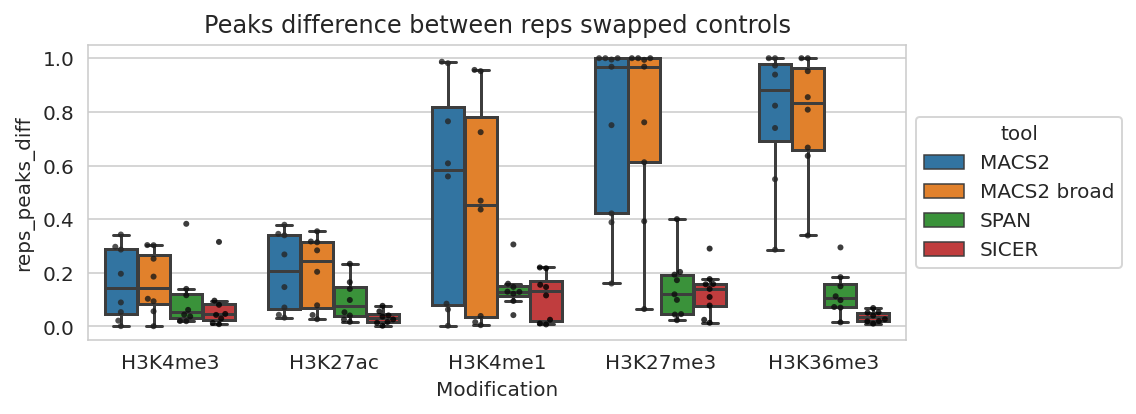

In [99]:
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=df_swapped_reps, x='modification', hue='tool', y='reps_peaks_diff',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=df_swapped_reps, x='modification', hue='tool', y='reps_peaks_diff',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.set_title('Peaks difference between reps swapped controls')
# ax.set_ylabel('Peaks difference')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

MACS2


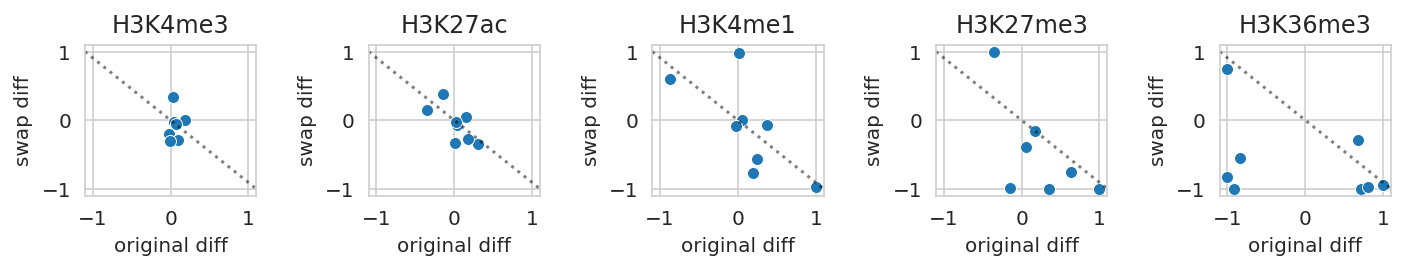

MACS2 broad


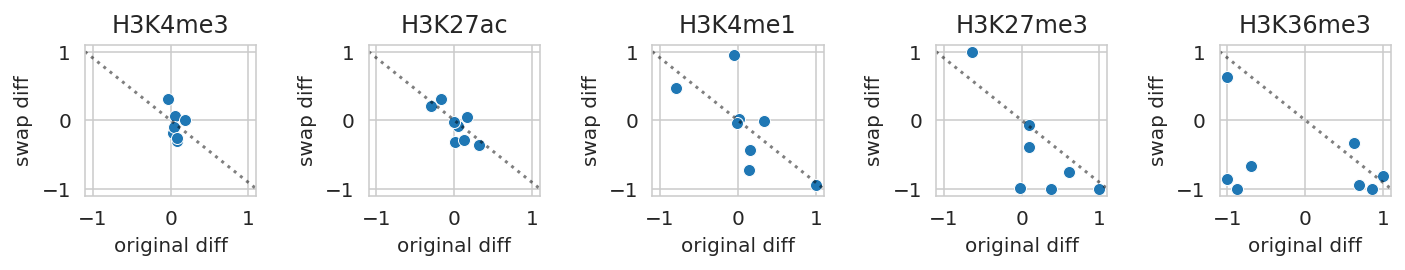

SPAN


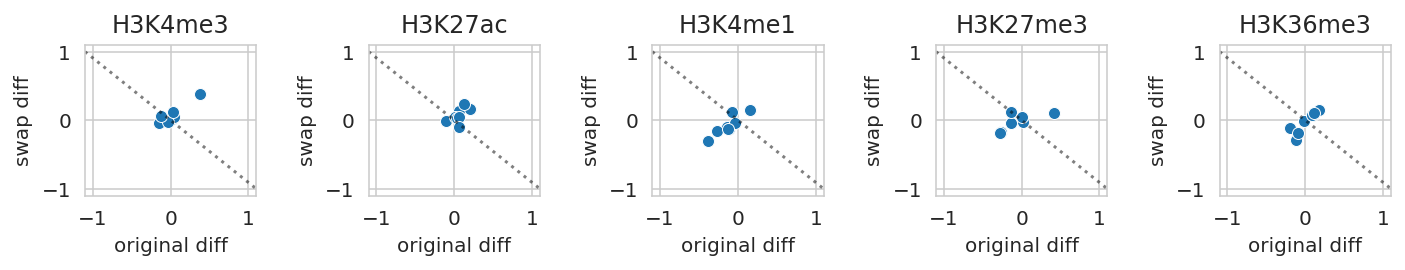

SICER


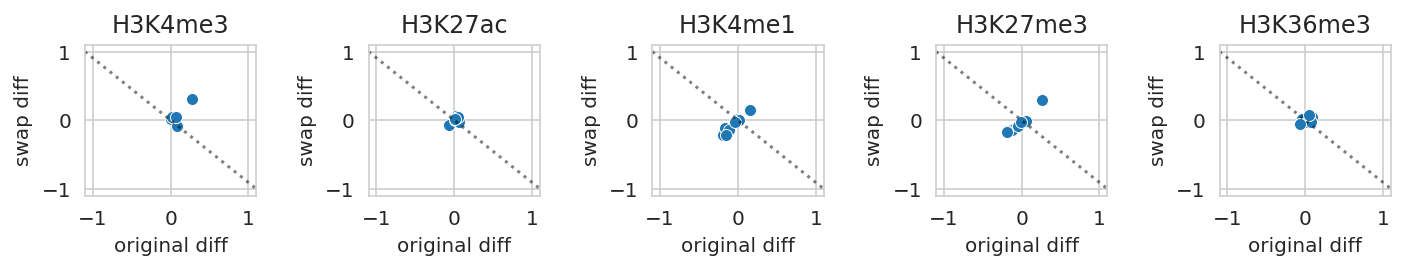

In [101]:
df_swapped_reps['swapped_reps_peaks_diff'] = \
    (df_swapped_reps['peaks1'] - df_swapped_reps['peaks2']) / (df_swapped_reps['peaks1'] + df_swapped_reps['peaks2'])
df_encode_reps['original_reps_peaks_diff'] = \
    (df_encode_reps['peaks1'] - df_encode_reps['peaks2']) / (df_encode_reps['peaks1'] + df_encode_reps['peaks2'])
t = pd.merge(df_swapped_reps, df_encode_reps, on=['modification', 'cell', 'tool', 'replicate1', 'replicate2'])

for tool in TOOLS:
    print(tool)
    plt.figure(figsize=(10, 2))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        tt = t[(t['modification'] == m) & (t['tool'] == tool)]
        sns.scatterplot(
            tt, x='original_reps_peaks_diff', y='swapped_reps_peaks_diff',
            ax=ax)
        sns.lineplot(x=[-1.1, 1.1], y=[1.0, -1.0], color='black', ax=ax, alpha=0.5, linestyle='dotted')
        ax.title.set_text(m)
        ax.set_xlabel('original diff')
        ax.set_ylabel('swap diff')
        ax.set_xlim(-1.1, 1.1)
        ax.set_ylim(-1.1, 1.1)
    plt.tight_layout()
    plt.show()

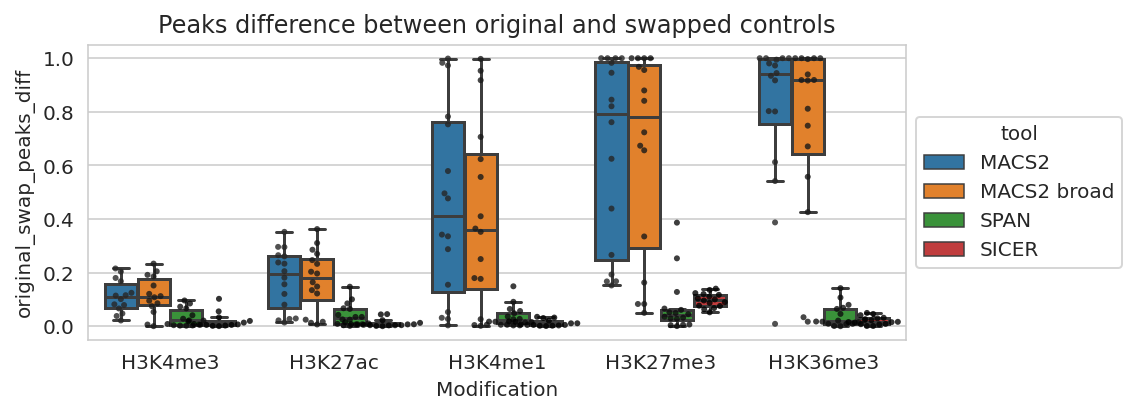

In [105]:
t = pd.merge(df_swapped[df_swapped['dataset'] == 'ENCODE'],
             df_peaks_original[['file', 'modification', 'cell', 'replicate', 'peaks', 'tool']],
             on=['modification', 'cell', 'replicate', 'tool'],
             suffixes=('_swapped', '_original'),
             how='inner')
t['original_swap_peaks_diff'] = [math.fabs(p1 - p2) / (p1 + p2) for _, (p1, p2) in
                                 t[['peaks_original', 'peaks_swapped']].iterrows()]

plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=t, x='modification', hue='tool', y='original_swap_peaks_diff',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=t, x='modification', hue='tool', y='original_swap_peaks_diff',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.set_title('Peaks difference between original and swapped controls')
# ax.set_ylabel('Peaks difference')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# Minimal control size for replicates

In [107]:
SAME_REPLICATE_CONTROL_SIZE_DIR = os.path.expanduser('~/data/2024_same_replicate_control_size')
! mkdir -p {SAME_REPLICATE_CONTROL_SIZE_DIR}/bams

In [ ]:
tf = tempfile.mktemp()

for _, (ds, m, c, r1, file1, cr1, control1, r2, file2, cr2, control2) in df_controls[
    ['dataset', 'modification', 'cell',
     'replicate1', 'file1', 'control_replicate1', 'control_file1',
     'replicate2', 'file2', 'control_replicate2', 'control_file2']].iterrows():
    control1_reads = df_bams[(df_bams['dataset'] == ds) &
                             (df_bams['modification'] == 'Control') &
                             (df_bams['cell'] == c) &
                             (df_bams['replicate'] == cr1)]['reads'].values[0]
    control2_reads = df_bams[(df_bams['dataset'] == ds) &
                             (df_bams['modification'] == 'Control') &
                             (df_bams['cell'] == c) &
                             (df_bams['replicate'] == cr2)]['reads'].values[0]

    print(ds, m, c)
    print(r1, file1, cr1, control1, control1_reads)
    print(r2, file2, cr2, control2, control2_reads)
    # Keep same signal
    ! ln -sf {file1} {SAME_REPLICATE_CONTROL_SIZE_DIR}/bams/{ds}_{m}_{c}_{r1}.bam
    ! ln -sf {file2} {SAME_REPLICATE_CONTROL_SIZE_DIR}/bams/{ds}_{m}_{c}_{r2}.bam

    control_min_reads = min(control1_reads, control2_reads)
    mln_reads = int(control_min_reads / 1e6)
    for (r, cfile, creads) in [(r1, control1, control1_reads), (r2, control2, control2_reads)]:
        print(f'Processing {r} {cfile} {creads}')
        ds_cfile = f'{SAME_REPLICATE_CONTROL_SIZE_DIR}/bams/{ds}_Control_{c}_{r}_{mln_reads}M_of_{int(creads / 1e6)}M.bam'
        print(ds_cfile)
        if not os.path.exists(ds_cfile):
            if creads <= mln_reads:
                ! ln -sf {cfile} {ds_cfile}
            else:
                print(f'Downsampling {cfile}')
                fraction = control_min_reads / creads
                ! samtools view -@ 4 -H {cfile} > {tf}.sam
                ! samtools view -@ 4 -s {fraction} {cfile} >> {tf}.sam
                ! samtools view -S -b {tf}.sam > {tf}.bam
                ! samtools sort {tf}.bam -o {ds_cfile}
                ! rm {tf}.sam {tf}.bam    

## Peak calling and visualization

```
conda activate snakemake
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" macs2=True --rerun-trigger mtime;
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1" macs2_suffix="broad0.1"  --rerun-trigger mtime; 
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" span=True sicer=True span_bin=200 span_gap=0 --rerun-trigger mtime; 

```

In [108]:
df_aligned_control = load_peaks_path(SAME_REPLICATE_CONTROL_SIZE_DIR, MODIFICATIONS, GSE26320_CELLS + IMMUNE_CELLS,
                                     GSE26320_REPS + IMMUNE_REPS)
df_aligned_control['dataset'] = ['ENCODE' if 'ENCODE' in f else 'Roadmap' for f in df_aligned_control['file']]
df_aligned_control.sample(5)

  0%|          | 0/656 [00:00<?, ?it/s]

MACS2 82


  0%|          | 0/656 [00:00<?, ?it/s]

MACS2 broad 82


  0%|          | 0/82 [00:00<?, ?it/s]

SICER 82


  0%|          | 0/185 [00:00<?, ?it/s]

SPAN 82


file modification   cell  \
147  /home/jetbrains/data/2024_same_replicate_contr...      H3K4me3  Huvec   
326  /home/jetbrains/data/2024_same_replicate_contr...      H3K27ac   NHEK   
4    /home/jetbrains/data/2024_same_replicate_contr...      H3K27ac   HMEC   
226  /home/jetbrains/data/2024_same_replicate_contr...      H3K4me1   NHLF   
251  /home/jetbrains/data/2024_same_replicate_contr...     H3K27me3   HSMM   

    replicate  peaks         tool dataset  
147      rep2  22807  MACS2 broad  ENCODE  
326      rep1  50232         SPAN  ENCODE  
4        rep2  32945        MACS2  ENCODE  
226      rep2  69276        SICER  ENCODE  
251      rep2  37722         SPAN  ENCODE

/tmp/ipykernel_522188/1416307472.py:11: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df_aligned_control[df_aligned_control['modification'] == m], x='tool', y='peaks',
/tmp/ipykernel_522188/1416307472.py:11: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df_aligned_control[df_aligned_control['modification'] == m], x='tool', y='peaks',
/tmp/ipykernel_522188/1416307472.py:11: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df_aligned_control[df_aligned_control['modification'] == m], x='tool', y='peaks',
/tmp/ipykernel_522188/1416307472.py:11: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df_aligned_control[df_aligned_control['modification'] == m], x='tool', y='peaks',
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 11.1% of the points cannot 

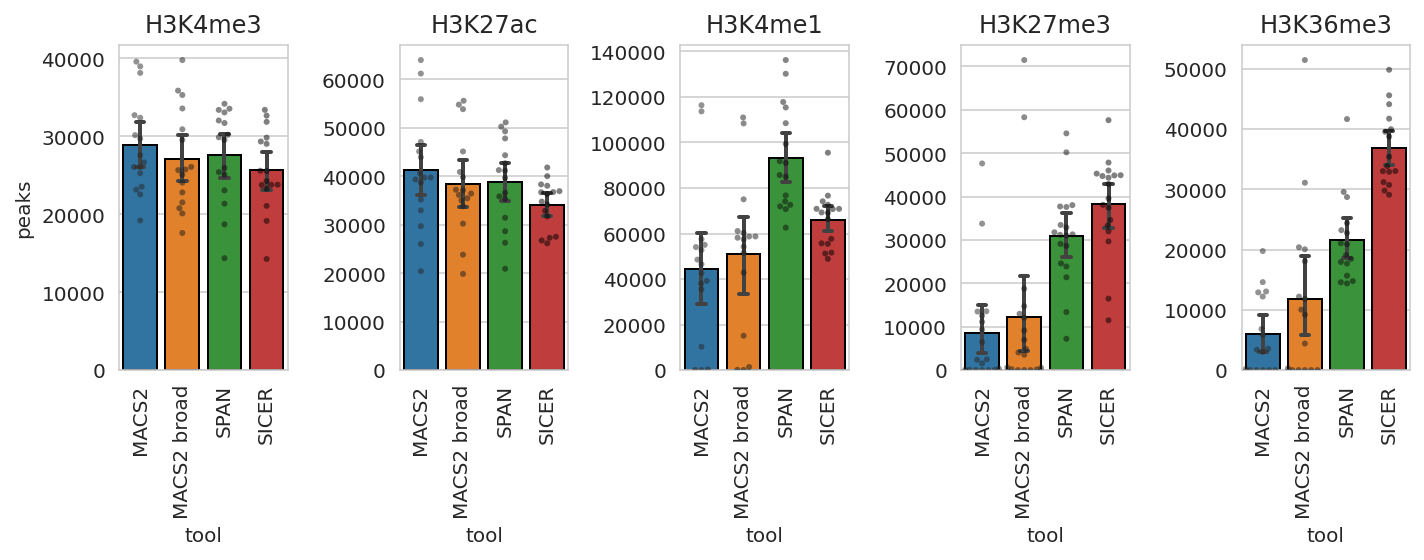

In [281]:
plt.figure(figsize=(10, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.barplot(data=df_aligned_control[df_aligned_control['modification'] == m], x='tool', y='peaks',
                # showfliers=False,
                capsize=.2, errwidth=2, edgecolor="black",
                palette=TOOLS_PALETTE,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                ax=ax)
    sns.swarmplot(data=df_aligned_control[df_aligned_control['modification'] == m], x='tool', y='peaks',
                  size=3, palette='dark:black', alpha=0.5,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    # ax.set_ylim(0, 1)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [110]:
df_aligned_control_reps = compute_reps_peaks(df_aligned_control, MODIFICATIONS, GSE26320_CELLS + IMMUNE_CELLS)
df_aligned_control_reps['reps_peaks_diff'] = np.fabs(
    (df_aligned_control_reps['peaks1'] - df_aligned_control_reps['peaks2']) /
    (df_aligned_control_reps['peaks1'] + df_aligned_control_reps['peaks2']))
df_aligned_control_reps.sample(5)

dataset modification     cell         tool replicate1 replicate2  peaks1  \
141  ENCODE      H3K4me3     HMEC  MACS2 broad       rep1       rep2   21521   
133  ENCODE      H3K4me3  GM12878  MACS2 broad       rep1       rep2   39791   
2    ENCODE      H3K27ac  GM12878        SICER       rep1       rep2   32865   
13   ENCODE      H3K27ac    HepG2  MACS2 broad       rep1       rep2   19845   
9    ENCODE      H3K27ac     HSMM  MACS2 broad       rep1       rep2   45103   

     peaks2  reps_peaks_diff  
141   17600         0.100227  
133   35307         0.059709  
2     31704         0.017981  
13    23814         0.090909  
9     53833         0.088239

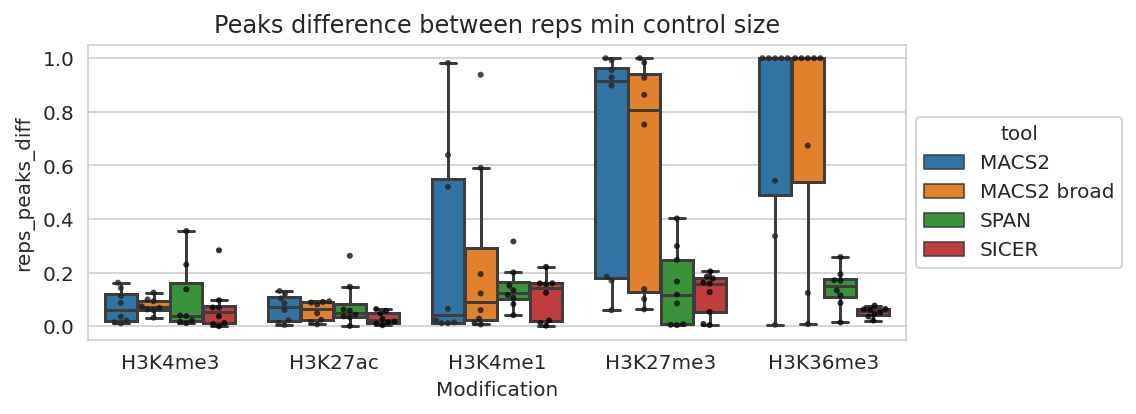

In [111]:
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=df_aligned_control_reps, x='modification', hue='tool', y='reps_peaks_diff',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=df_aligned_control_reps, x='modification', hue='tool', y='reps_peaks_diff',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.set_title('Peaks difference between reps min control size')
# ax.set_ylabel('Peaks difference')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

MACS2


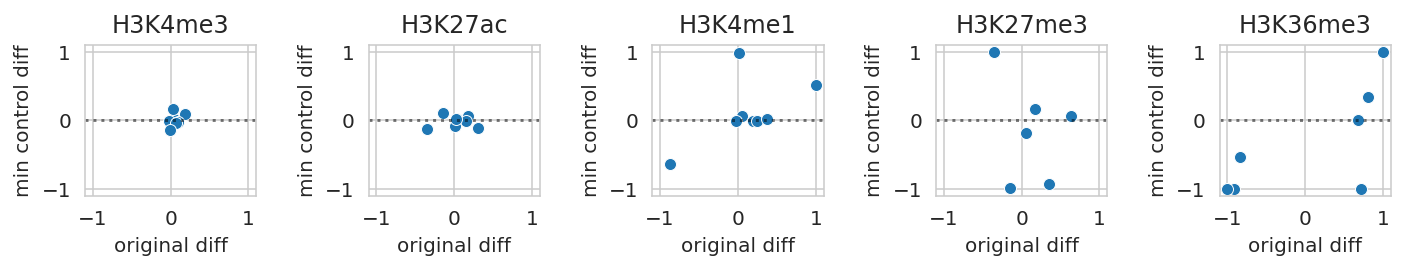

MACS2 broad


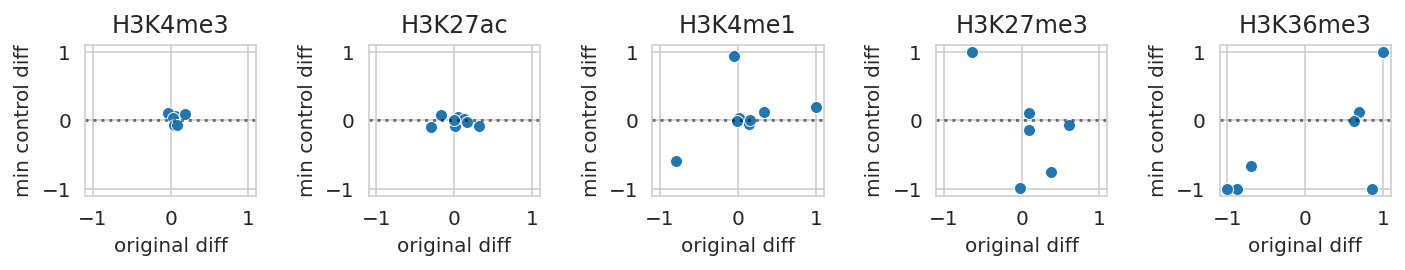

SPAN


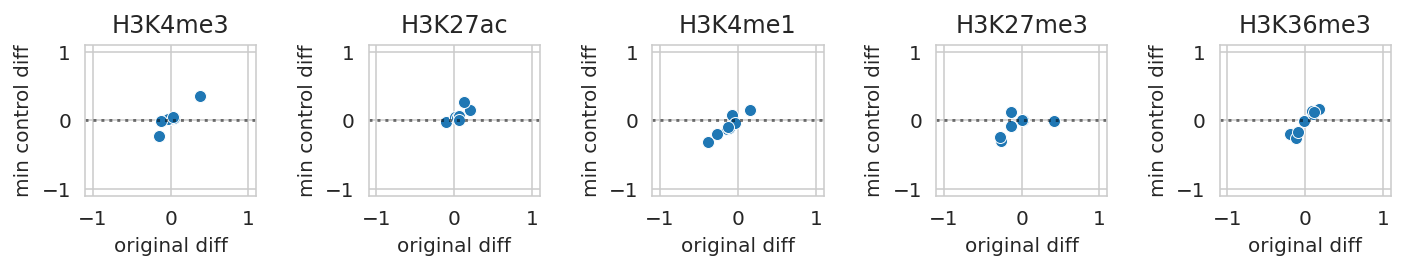

SICER


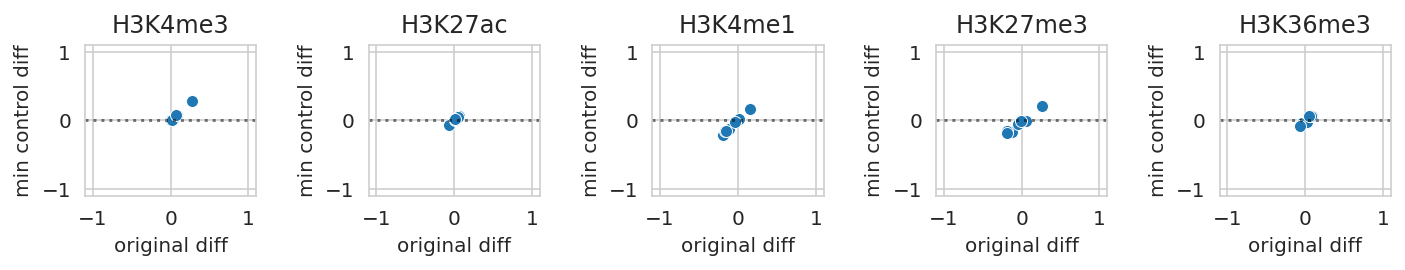

In [113]:
df_aligned_control_reps['min_control_reps_peaks_diff'] = \
    (df_aligned_control_reps['peaks1'] - df_aligned_control_reps['peaks2']) / (
            df_aligned_control_reps['peaks1'] + df_aligned_control_reps['peaks2'])
df_encode_reps['original_reps_peaks_diff'] = \
    (df_encode_reps['peaks1'] - df_encode_reps['peaks2']) / (df_encode_reps['peaks1'] + df_encode_reps['peaks2'])
t = pd.merge(df_aligned_control_reps, df_encode_reps, on=['modification', 'cell', 'tool', 'replicate1', 'replicate2'])

for tool in TOOLS:
    print(tool)
    plt.figure(figsize=(10, 2))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        tt = t[(t['modification'] == m) & (t['tool'] == tool)]
        sns.scatterplot(
            tt, x='original_reps_peaks_diff', y='min_control_reps_peaks_diff',
            ax=ax)
        sns.lineplot(x=[-1.1, 1.1], y=[0, 0], color='black', ax=ax, alpha=0.5, linestyle='dotted')
        ax.title.set_text(m)
        ax.set_xlabel('original diff')
        ax.set_ylabel('min control diff')
        ax.set_xlim(-1.1, 1.1)
        ax.set_ylim(-1.1, 1.1)
    plt.tight_layout()
    plt.show()

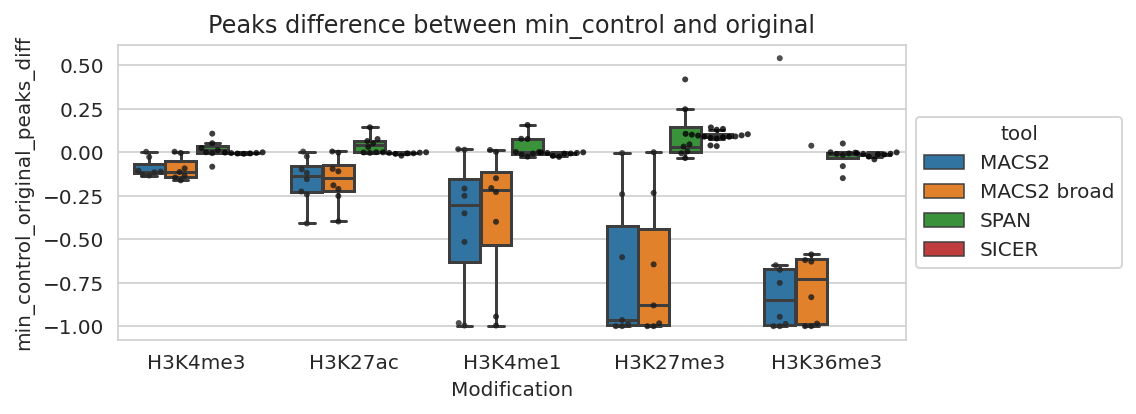

In [280]:
t = pd.merge(df_aligned_control,
             df_peaks_original[['file', 'modification', 'cell', 'replicate', 'peaks', 'tool']],
             on=['modification', 'cell', 'replicate', 'tool'],
             suffixes=('_min_control', '_original'),
             how='inner')
t['min_control_original_peaks_diff'] = [d(p - po, p + po) for _, (p, po) in
                                        t[['peaks_min_control', 'peaks_original']].iterrows()]

plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=t[t['min_control_original_peaks_diff'] != 0],
            x='modification', hue='tool', y='min_control_original_peaks_diff',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=t[t['min_control_original_peaks_diff'] != 0],
              x='modification', hue='tool', y='min_control_original_peaks_diff',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.set_title('Peaks difference between min_control and original')
# ax.set_ylabel('Peaks difference')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# Downscale Roadmap controls to 10/5/2/1 mln reads

In [123]:
IMMUNE_CONTROL_DOWNSCALE = os.path.expanduser('~/data/2024_immune_control_downscale')
MLNS = [10, 5, 2, 1]
for mln in MLNS:
    print(f'{IMMUNE_CONTROL_DOWNSCALE}_{mln}M')
    ! mkdir -p {IMMUNE_CONTROL_DOWNSCALE}_{mln}M/bams

/home/jetbrains/data/2024_immune_control_downscale_10M
/home/jetbrains/data/2024_immune_control_downscale_5M
/home/jetbrains/data/2024_immune_control_downscale_2M
/home/jetbrains/data/2024_immune_control_downscale_1M


In [124]:
tf = tempfile.mktemp()

for mln in MLNS:
    print(mln)
    for _, row in tqdm(list(df_bams[df_bams['cell'].isin(['TCell', 'BCell', 'Monocyte'])].iterrows())):
        bam_file, m, c, r, reads = row['bam_file'], row['modification'], row['cell'], row['replicate'], row['reads']
        print(bam_file, m, c, r, reads)
        if m != 'Control' or reads < mln * 1e6:
            # Keep same signal
            ! ln -sf {bam_file} {IMMUNE_CONTROL_DOWNSCALE}_{mln}M/bams/{m}_{c}_{r}.bam
        else:
            ds_cfile = f'{IMMUNE_CONTROL_DOWNSCALE}_{mln}M/bams/Control_{c}_{r}.bam'
            if not os.path.exists(ds_cfile):
                fraction = mln * 1e6 / reads
                print(f'Downsampling {bam_file} by {fraction}')
                ! samtools view -@ 4 -H {bam_file} > {tf}.sam
                ! samtools view -@ 4 -s {fraction} {bam_file} >> {tf}.sam
                ! samtools view -S -b {tf}.sam > {tf}.bam
                ! samtools sort {tf}.bam -o {ds_cfile}
                ! rm {tf}.sam {tf}.bam    

10


  0%|          | 0/18 [00:00<?, ?it/s]

/home/jetbrains/data/2023_Immune/bams/TCell_Control_hg38_ENCFF566HDE.bam Control TCell  35331343
Downsampling /home/jetbrains/data/2023_Immune/bams/TCell_Control_hg38_ENCFF566HDE.bam by 0.2830348113288533
[bam_sort_core] merging from 3 files and 1 in-memory blocks...
/home/jetbrains/data/2023_Immune/bams/BCell_H3K27ac_hg38_ENCFF404HKA.bam H3K27ac BCell  21067933
/home/jetbrains/data/2023_Immune/bams/TCell_H3K4me3_hg38_ENCFF661HCG.bam H3K4me3 TCell  28746534
/home/jetbrains/data/2023_Immune/bams/BCell_H3K4me1_hg38_ENCFF584OXC.bam H3K4me1 BCell  28811580
/home/jetbrains/data/2023_Immune/bams/BCell_H3K36me3_hg38_ENCFF207YSM.bam H3K36me3 BCell  22597809
/home/jetbrains/data/2023_Immune/bams/Monocyte_H3K27me3_gh38_ENCFF850DZD.bam H3K27me3 Monocyte  22268131
/home/jetbrains/data/2023_Immune/bams/BCell_Control_hg38_ENCFF198QJK.bam Control BCell  29198392
Downsampling /home/jetbrains/data/2023_Immune/bams/BCell_Control_hg38_ENCFF198QJK.bam by 0.34248461353625226
[bam_sort_core] merging from 3 

  0%|          | 0/18 [00:00<?, ?it/s]

/home/jetbrains/data/2023_Immune/bams/TCell_Control_hg38_ENCFF566HDE.bam Control TCell  35331343
Downsampling /home/jetbrains/data/2023_Immune/bams/TCell_Control_hg38_ENCFF566HDE.bam by 0.14151740566442664
[bam_sort_core] merging from 1 files and 1 in-memory blocks...
/home/jetbrains/data/2023_Immune/bams/BCell_H3K27ac_hg38_ENCFF404HKA.bam H3K27ac BCell  21067933
/home/jetbrains/data/2023_Immune/bams/TCell_H3K4me3_hg38_ENCFF661HCG.bam H3K4me3 TCell  28746534
/home/jetbrains/data/2023_Immune/bams/BCell_H3K4me1_hg38_ENCFF584OXC.bam H3K4me1 BCell  28811580
/home/jetbrains/data/2023_Immune/bams/BCell_H3K36me3_hg38_ENCFF207YSM.bam H3K36me3 BCell  22597809
/home/jetbrains/data/2023_Immune/bams/Monocyte_H3K27me3_gh38_ENCFF850DZD.bam H3K27me3 Monocyte  22268131
/home/jetbrains/data/2023_Immune/bams/BCell_Control_hg38_ENCFF198QJK.bam Control BCell  29198392
Downsampling /home/jetbrains/data/2023_Immune/bams/BCell_Control_hg38_ENCFF198QJK.bam by 0.17124230676812613
[bam_sort_core] merging from 1

  0%|          | 0/18 [00:00<?, ?it/s]

/home/jetbrains/data/2023_Immune/bams/TCell_Control_hg38_ENCFF566HDE.bam Control TCell  35331343
Downsampling /home/jetbrains/data/2023_Immune/bams/TCell_Control_hg38_ENCFF566HDE.bam by 0.05660696226577065
/home/jetbrains/data/2023_Immune/bams/BCell_H3K27ac_hg38_ENCFF404HKA.bam H3K27ac BCell  21067933
/home/jetbrains/data/2023_Immune/bams/TCell_H3K4me3_hg38_ENCFF661HCG.bam H3K4me3 TCell  28746534
/home/jetbrains/data/2023_Immune/bams/BCell_H3K4me1_hg38_ENCFF584OXC.bam H3K4me1 BCell  28811580
/home/jetbrains/data/2023_Immune/bams/BCell_H3K36me3_hg38_ENCFF207YSM.bam H3K36me3 BCell  22597809
/home/jetbrains/data/2023_Immune/bams/Monocyte_H3K27me3_gh38_ENCFF850DZD.bam H3K27me3 Monocyte  22268131
/home/jetbrains/data/2023_Immune/bams/BCell_Control_hg38_ENCFF198QJK.bam Control BCell  29198392
Downsampling /home/jetbrains/data/2023_Immune/bams/BCell_Control_hg38_ENCFF198QJK.bam by 0.06849692270725045
/home/jetbrains/data/2023_Immune/bams/Monocyte_H3K4me3_hg38_ENCFF642LZZ.bam H3K4me3 Monocyte 

  0%|          | 0/18 [00:00<?, ?it/s]

/home/jetbrains/data/2023_Immune/bams/TCell_Control_hg38_ENCFF566HDE.bam Control TCell  35331343
Downsampling /home/jetbrains/data/2023_Immune/bams/TCell_Control_hg38_ENCFF566HDE.bam by 0.028303481132885326
/home/jetbrains/data/2023_Immune/bams/BCell_H3K27ac_hg38_ENCFF404HKA.bam H3K27ac BCell  21067933
/home/jetbrains/data/2023_Immune/bams/TCell_H3K4me3_hg38_ENCFF661HCG.bam H3K4me3 TCell  28746534
/home/jetbrains/data/2023_Immune/bams/BCell_H3K4me1_hg38_ENCFF584OXC.bam H3K4me1 BCell  28811580
/home/jetbrains/data/2023_Immune/bams/BCell_H3K36me3_hg38_ENCFF207YSM.bam H3K36me3 BCell  22597809
/home/jetbrains/data/2023_Immune/bams/Monocyte_H3K27me3_gh38_ENCFF850DZD.bam H3K27me3 Monocyte  22268131
/home/jetbrains/data/2023_Immune/bams/BCell_Control_hg38_ENCFF198QJK.bam Control BCell  29198392
Downsampling /home/jetbrains/data/2023_Immune/bams/BCell_Control_hg38_ENCFF198QJK.bam by 0.03424846135362523
/home/jetbrains/data/2023_Immune/bams/Monocyte_H3K4me3_hg38_ENCFF642LZZ.bam H3K4me3 Monocyte

## Peak calling and visualization

```
conda activate snakemake

for M in 10 5 2 1; do echo $M;
cd /home/jetbrains/data/2024_immune_control_downscale_${M}M;
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" macs2=True --rerun-trigger mtime;
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1" macs2_suffix="broad0.1"  --rerun-trigger mtime; 
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" span=True sicer=True span_bin=200 span_gap=0 --rerun-trigger mtime; 
done
```

In [219]:
ts = []
for mln in MLNS:
    t = load_peaks_path(f'{IMMUNE_CONTROL_DOWNSCALE}_{mln}M', 
                        MODIFICATIONS, GSE26320_CELLS + IMMUNE_CELLS,
                        GSE26320_REPS + IMMUNE_REPS)
    t['mln'] = mln
    ts.append(t)
df_immune_mln_controls = pd.concat(ts).reset_index(drop=True)
df_immune_mln_controls.sample(3)

  0%|          | 0/120 [00:00<?, ?it/s]

MACS2 15


  0%|          | 0/120 [00:00<?, ?it/s]

MACS2 broad 15


  0%|          | 0/15 [00:00<?, ?it/s]

SICER 15


  0%|          | 0/34 [00:00<?, ?it/s]

SPAN 15


  0%|          | 0/120 [00:00<?, ?it/s]

MACS2 15


  0%|          | 0/120 [00:00<?, ?it/s]

MACS2 broad 15


  0%|          | 0/15 [00:00<?, ?it/s]

SICER 15


  0%|          | 0/34 [00:00<?, ?it/s]

SPAN 15


  0%|          | 0/120 [00:00<?, ?it/s]

MACS2 15


  0%|          | 0/120 [00:00<?, ?it/s]

MACS2 broad 15


  0%|          | 0/15 [00:00<?, ?it/s]

SICER 15


  0%|          | 0/34 [00:00<?, ?it/s]

SPAN 15


  0%|          | 0/120 [00:00<?, ?it/s]

MACS2 15


  0%|          | 0/120 [00:00<?, ?it/s]

MACS2 broad 15


  0%|          | 0/15 [00:00<?, ?it/s]

SICER 15


  0%|          | 0/34 [00:00<?, ?it/s]

SPAN 15


file modification   cell  \
68   /home/jetbrains/data/2024_immune_control_downs...      H3K27ac  BCell   
157  /home/jetbrains/data/2024_immune_control_downs...      H3K27ac  BCell   
191  /home/jetbrains/data/2024_immune_control_downs...     H3K27me3  BCell   

    replicate  peaks   tool  mln  
68             25568  MACS2    5  
157            24808  SICER    2  
191                0  MACS2    1

In [220]:
t = df_immune_peaks[(df_immune_peaks['cell'].isin(['TCell', 'BCell', 'Monocyte'])) &
                    (df_immune_peaks['control'] == True)].copy()
t['mln'] = 20
df_immune_mln_controls = pd.concat([df_immune_mln_controls, t]).reset_index(drop=True)
df_immune_mln_controls['dataset'] = 'Roadmap'
df_immune_mln_controls.sample(3)

file modification      cell  \
142  /home/jetbrains/data/2024_immune_control_downs...     H3K27me3  Monocyte   
83   /home/jetbrains/data/2024_immune_control_downs...      H3K4me1  Monocyte   
277  /home/jetbrains/data/2023_Immune/sicer/TCell_H...     H3K27me3     TCell   

    replicate  peaks         tool  mln  dataset control  
142            11977  MACS2 broad    2  Roadmap     NaN  
83             80669  MACS2 broad    5  Roadmap     NaN  
277            67477        SICER   20  Roadmap    True

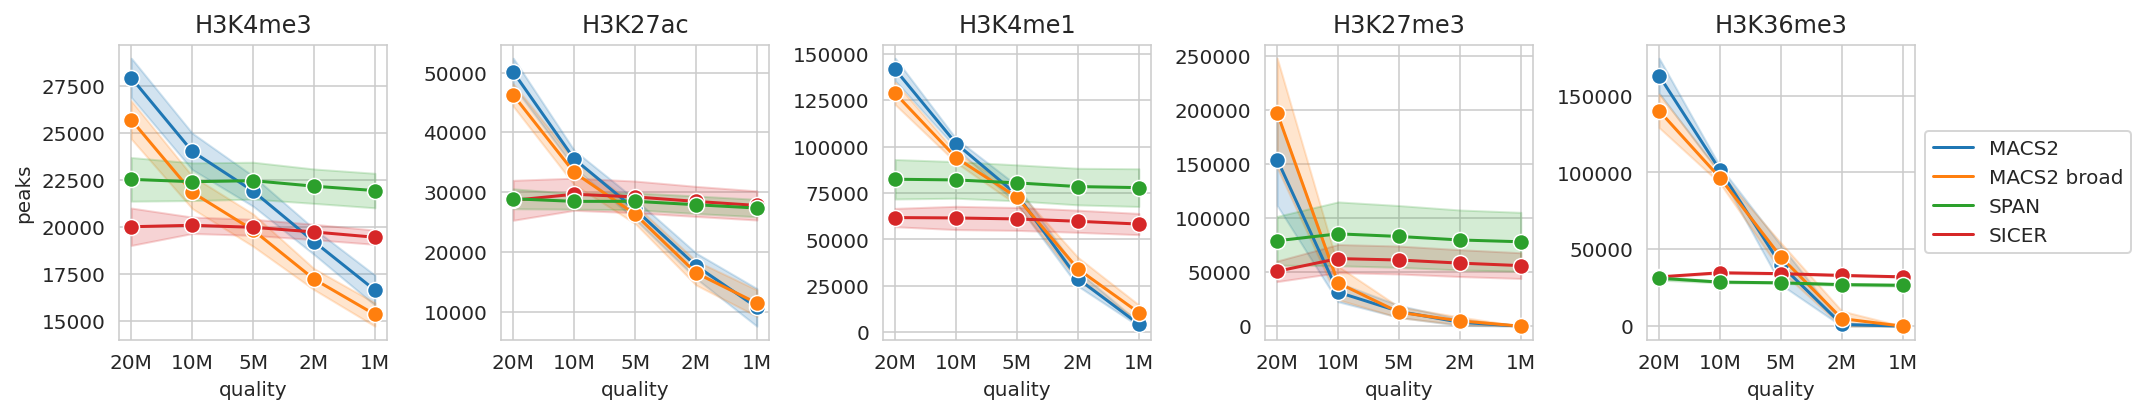

In [159]:
plt.figure(figsize=(15, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    t = df_immune_mln_controls[df_immune_mln_controls['modification'] == m].copy()
    t.sort_values(by=['mln'], ascending=False, inplace=True)
    t['quality'] = [f'{mln}M' for mln in t['mln']]
    for tool in ['MACS2', 'MACS2 broad', 'SICER', 'SPAN']:
        sns.lineplot(data=t[t['tool'] == tool], x='quality', y='peaks', hue='tool',
                     hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                     palette=TOOLS_PALETTE,
                     # errorbar=('sd', .5), 
                    errorbar='se',
                    marker='o', markersize=8,
                     legend=tool=='SPAN',
                    ax=ax)
    ax.set_title(m)
    if i > 0:
        ax.set_ylabel(None)
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [150]:
t = []
for _, (m, c, r, tool, p, mln) in df_immune_mln_controls[['modification', 'cell', 'replicate', 'tool', 'peaks', 'mln']].iterrows():
    if mln == 20:
        t.append(0)
    else:
        peaks20m = df_immune_mln_controls[(df_immune_mln_controls['modification'] == m) &
                                          (df_immune_mln_controls['cell'] == c) &
                                          (df_immune_mln_controls['replicate'] == r) &
                                          (df_immune_mln_controls['tool'] == tool) &
                                          (df_immune_mln_controls['mln'] == 20)]['peaks'].values[0]
        t.append(100 * p / peaks20m - 100)
df_immune_mln_controls['delta_peaks'] = t
df_immune_mln_controls.sample(3)

file modification      cell  \
95   /home/jetbrains/data/2024_immune_control_downs...      H3K4me1  Monocyte   
160  /home/jetbrains/data/2024_immune_control_downs...     H3K27me3     TCell   
175  /home/jetbrains/data/2024_immune_control_downs...      H3K4me1     TCell   

    replicate  peaks   tool  mln dataset control  delta_peaks  
95             73215  SICER    5     NaN     NaN     4.299329  
160            79179  SICER    2     NaN     NaN    17.342205  
175            63717   SPAN    2     NaN     NaN    -1.417233

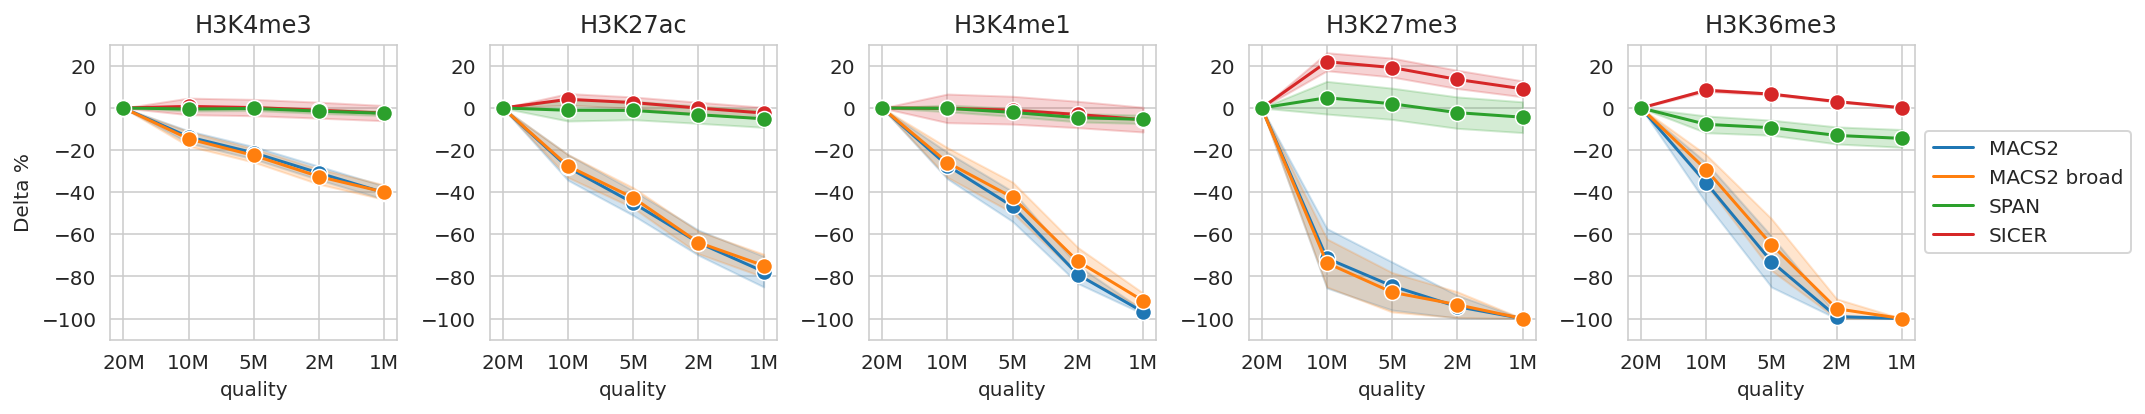

In [156]:
plt.figure(figsize=(15, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    t = df_immune_mln_controls[df_immune_mln_controls['modification'] == m].copy()
    t.sort_values(by=['mln'], ascending=False, inplace=True)
    t['quality'] = [f'{mln}M' for mln in t['mln']]
    for tool in ['MACS2', 'MACS2 broad', 'SICER', 'SPAN']:
        sns.lineplot(data=t[t['tool'] == tool], x='quality', y='delta_peaks', hue='tool',
                     hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                     palette=TOOLS_PALETTE,
                     # errorbar=('sd', .5), 
                     errorbar='se',
                     marker='o', markersize=8,
                     legend = tool == 'SPAN',
                     ax=ax,
                     )
    ax.set_title(m)
    ax.set_ylim(-110, 30)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('Delta %')
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
plt.tight_layout()
plt.show()

# BigWigs

In [167]:
# Prepare BAM files
WD = os.path.expanduser('~/data/2023_wiggle')

BLACKLIST_PATH = WD + '/hg38-blacklist.v2.bed'
blacklist_df = pd.read_csv(BLACKLIST_PATH, sep='\t', header=None)
blacklist_df.rename({0: 'chr', 1: 'start', 2: 'end'}, axis=1, inplace=True)
blacklist_df

chr     start       end                   3
0    chr10         0     45700     Low Mappability
1    chr10  38481300  38596500  High Signal Region
2    chr10  38782600  38967900  High Signal Region
3    chr10  39901300  41712900  High Signal Region
4    chr10  41838900  42107300  High Signal Region
..     ...       ...       ...                 ...
631   chrY   4343800   4345800  High Signal Region
632   chrY  10246200  11041200  High Signal Region
633   chrY  11072100  11335300  High Signal Region
634   chrY  11486600  11757800  High Signal Region
635   chrY  26637300  57227400  High Signal Region

[636 rows x 4 columns]

In [164]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(GSE26320_PATH, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}


def load_bws(path, modification, cells, replicates, control='Input'):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        mod = next((m for m in modification if m in f), None)
        if mod is None and control is not None and control in f:
            mod = 'Control'
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        if mod and cell and rep is not None:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), mod, cell, rep)
    return df_bws

In [179]:
ts = []
for mln in MLNS:
    t = load_bws(f'{IMMUNE_CONTROL_DOWNSCALE}_{mln}M/bw', MODIFICATIONS + ['Control'], ['TCell', 'BCell', 'Monocyte'], IMMUNE_REPS)
    t['mln'] = mln
    ts.append(t)
all_bws = pd.concat(ts).reset_index(drop=True)
all_bws['dataset'] = 'Roadmap'
all_bws.sample(3)
all_bws['modification'].unique()

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

array(['H3K4me1', 'H3K27ac', 'Control', 'H3K27me3', 'H3K36me3', 'H3K4me3'],
      dtype=object)

In [206]:
import pyBigWig

total_coverages = {}
ts = []
for _, (ds, m, c, r, mln) in tqdm(list(all_bws[['dataset', 'modification', 'cell', 'replicate', 'mln']].iterrows())):
    print(ds, m, c, r)
    t = all_bws[(all_bws['modification'] == m) &
                (all_bws['cell'] == c) &
                (all_bws['replicate'] == r) &
                (all_bws['mln'] == mln) &
                (all_bws['dataset'] == ds)]
    if len(t) == 0:
        continue
    bw_path = t['file'].values[0]
    # print(bw_path)

    try:
        with pyBigWig.open(bw_path) as bw:
            total_coverage = sum(bw.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr)
            print('Total coverage', total_coverage)
            # Multiplier to align BAM coverage with BigWig estimation
            total_coverage *= 1.1e-2
            total_coverages[(ds, m, c, r, mln)] = total_coverage
    except Exception:
        pass
        # print('ERROR')

total_coverages_df = pd.DataFrame([(ds, m, c, r, mln, n) for (ds, m, c, r, mln), n in total_coverages.items()],
                                  columns=['dataset', 'modification', 'cell', 'replicate', 'mln', 'reads'])
total_coverages_df.sample(5)
total_coverages_df['modification'].unique()

  0%|          | 0/72 [00:00<?, ?it/s]

Roadmap H3K4me1 TCell 
Total coverage 1927032109.0
Roadmap H3K27ac Monocyte 
Total coverage 1762350697.0
Roadmap Control BCell 
Total coverage 848937078.0
Roadmap H3K4me1 Monocyte 
Total coverage 2567465245.0
Roadmap Control TCell 
Total coverage 848684683.0
Roadmap H3K27me3 Monocyte 
Total coverage 1890731157.0
Roadmap H3K36me3 TCell 
Total coverage 1898549288.0
Roadmap H3K4me3 TCell 
Total coverage 2440582169.0
Roadmap H3K4me3 Monocyte 
Total coverage 1748212269.0
Roadmap H3K27ac TCell 
Total coverage 2583459992.0
Roadmap H3K27me3 TCell 
Total coverage 2170976302.0
Roadmap H3K4me1 BCell 
Total coverage 2447063695.0
Roadmap H3K36me3 Monocyte 
Total coverage 1709273450.0
Roadmap H3K36me3 BCell 
Total coverage 1919235238.0
Roadmap H3K27me3 BCell 
Total coverage 2212292438.0
Roadmap H3K4me3 BCell 
Total coverage 2092561107.0
Roadmap Control Monocyte 
Total coverage 848449252.0
Roadmap H3K27ac BCell 
Total coverage 1788963461.0
Roadmap H3K4me1 TCell 
Total coverage 1927032109.0
Roadmap H3

array(['H3K4me1', 'H3K27ac', 'Control', 'H3K27me3', 'H3K36me3', 'H3K4me3'],
      dtype=object)

In [172]:
import pyBigWig

def collect_bw_stats(bw_path, control_bw_path, chrom_sizes, blacklist, region, top_regions, work_regions, resolution):
    print('Prepare chromosome indexes')
    chr_indx = {}
    indx = 0
    for chr, chr_size in chrom_sizes.items():
        if '_' in chr:
            continue
        bins = int(math.floor(chr_size / region))
        chr_indx[chr] = (indx, indx + bins)
        indx += bins
    chromosomes = list(chr_indx.keys())

    print('Compute coverage in regions')
    region_coverages = np.zeros(indx)
    with pyBigWig.open(bw_path) as bw:
        for chr, (istart, iend) in chr_indx.items():
            region_coverages[istart: iend] = \
                np.array(
                    [x or 0 for x in bw.stats(chr, 1, CHROM_SIZES[chr], nBins=iend - istart, exact=True, type='sum')])

    print('Processing blacklisted regions')
    blacklist_marked = 0
    for chr, start, end in zip(blacklist['chr'], blacklist['start'], blacklist['end']):
        if chr not in chr_indx:
            continue
        offset = chr_indx[chr][0]
        for x in range(int(math.floor(start / region)), int(math.ceil(end / region)) + 1):
            region_coverages[min(x - offset, len(region_coverages) - 1)] = 0
            blacklist_marked += 1
    print(f'Marked {blacklist_marked} / {len(region_coverages)} bins as blacklist')

    if top_regions > len(region_coverages):
        raise Exception(f'Too many top regions {top_regions} > {len(region_coverages)}')

    print('Split by chromosomes')
    chr_xs = [[] for _ in range(len(chr_indx))]  # Create new array for each chromosome index
    ichr = 0
    for x in np.sort(np.argpartition(region_coverages, -top_regions)[-top_regions:]):
        while chr_indx[chromosomes[ichr]][1] < x:
            ichr += 1
        chr_xs[ichr].append(x)

    print('Collect final regions')
    peaks = []
    for ichr, xs in enumerate(chr_xs):
        chr = chromosomes[ichr]
        offset = chr_indx[chr][0]
        for i, x in enumerate(xs):
            peaks.append((chr, (x - offset) * region, (x + 1 - offset) * region))
    df = pd.DataFrame(peaks, columns=['chromosome', 'start', 'end'])
    if len(df) > work_regions:
        print(f'Pick {work_regions} / {top_regions} uniform regions for computation speedup')
        step = int(math.ceil(len(df) / float(work_regions)))
        df = df.iloc[range(0, len(df), step)].copy()

    print('Collecting bigwig stats')
    sums, means, stds, control_sums, control_means, control_stds = [], [], [], [], [], []
    with pyBigWig.open(bw_path) as bw:
        with pyBigWig.open(control_bw_path) as cbw:
            for _, (chr, start, end) in df.iterrows():
                stats = np.array(bw.stats(
                    chr, start, end, nBins=int(math.ceil((end - start) / resolution)), exact=True, type='sum'))
                sums.append(np.sum(stats))
                means.append(np.mean(stats))
                stds.append(np.std(stats))
                control_stats = np.array(cbw.stats(
                    chr, start, end, nBins=int(math.ceil((end - start) / resolution)), exact=True, type='sum'))
                control_sums.append(np.sum(control_stats))
                control_means.append(np.mean(control_stats))
                control_stds.append(np.std(control_stats))
    df['sum'] = sums
    df['mean'] = means
    df['std'] = stds
    df['control_sum'] = control_sums
    df['control_mean'] = control_means
    df['control_std'] = control_stds
    return df

In [257]:
REGION = 10_000
TOP_REGIONS = 50_000
WORK_REGIONS = 1000
RESOLUTION = 50

# Compute on top chromosomes for speed
chrom_sizes_part = {f'chr{i + 1}': CHROM_SIZES[f'chr{i + 1}'] for i in range(3)}

ts = []
for _, (bw_path, ds, mln, m, c, r) in tqdm(
        list(all_bws[['file', 'dataset', 'mln', 'modification', 'cell', 'replicate']].iterrows())):
    if m == 'Control':
        continue
    cr = r
    ct = all_bws[(all_bws['modification'] == 'Control') &
                 (all_bws['mln'] == mln) &
                 (all_bws['cell'] == c) &
                 (all_bws['replicate'] == cr) &
                 (all_bws['dataset'] == ds)]
    # Control can be different for Roadmap
    if len(ct) == 0:
        cr = ''
        ct = all_bws[(all_bws['modification'] == 'Control') &
                     (all_bws['mln'] == mln) &
                     (all_bws['cell'] == c) &
                     (all_bws['replicate'] == cr) &
                     (all_bws['dataset'] == ds)]
    if len(ct) == 0:
        continue
    print(ds, m, c, r)
    cbw_path = ct['file'].values[0]
    print(bw_path, cbw_path)
    df = collect_bw_stats(bw_path, cbw_path, chrom_sizes_part, blacklist_df, REGION, TOP_REGIONS, WORK_REGIONS, RESOLUTION)
    df['dataset'] = ds
    df['modification'] = m
    df['cell'] = c
    df['replicate'] = r
    df['mln'] = mln
    df['control_replicate'] = cr
    df['rpkm'] = df['sum'] / ((REGION / 1e3) * ((total_coverages[(ds, m, c, r, mln)]) / 1e6))
    df['control_reads'] = total_coverages[(ds, 'Control', c, cr, mln)]
    df['control_rpkm'] = df['control_sum'] / ((REGION / 1e3) * ((total_coverages[(ds, 'Control', c, cr, mln)]) / 1e6))
    df['signal_to_control'] = [d(s, c) for s, c in zip(df['rpkm'], df['control_rpkm'])]
    ts.append(df)
df_bw_stats = pd.concat(ts).reset_index(drop=True)
df_bw_stats.sample(5)

  0%|          | 0/72 [00:00<?, ?it/s]

Roadmap H3K4me1 TCell 
/home/jetbrains/data/2024_immune_control_downscale_10M/bw/H3K4me1_TCell_.bw /home/jetbrains/data/2024_immune_control_downscale_10M/bw/Control_TCell_.bw
Prepare chromosome indexes
Compute coverage in regions
Processing blacklisted regions
Marked 3864 / 68943 bins as blacklist
Split by chromosomes
Collect final regions
Pick 1000 / 50000 uniform regions for computation speedup
Roadmap H3K27ac Monocyte 
/home/jetbrains/data/2024_immune_control_downscale_10M/bw/H3K27ac_Monocyte_.bw /home/jetbrains/data/2024_immune_control_downscale_10M/bw/Control_Monocyte_.bw
Prepare chromosome indexes
Compute coverage in regions
Processing blacklisted regions
Marked 3864 / 68943 bins as blacklist
Split by chromosomes
Collect final regions
Pick 1000 / 50000 uniform regions for computation speedup
Roadmap H3K4me1 Monocyte 
/home/jetbrains/data/2024_immune_control_downscale_10M/bw/H3K4me1_Monocyte_.bw /home/jetbrains/data/2024_immune_control_downscale_10M/bw/Control_Monocyte_.bw
Prepare

chromosome      start        end       sum    mean          std  \
4597        chr2  169680000  169690000    3300.0   16.50    29.626846   
43028       chr1   26310000   26320000  150400.0  752.00  1289.572022   
6803        chr3   70360000   70370000    4900.0   24.50    37.745861   
13721       chr3   15060000   15070000   60350.0  301.75   842.071516   
48935       chr3  155340000  155350000    3350.0   16.75    27.512497   

       control_sum  control_mean  control_std  dataset modification      cell  \
4597        3000.0         15.00    30.000000  Roadmap     H3K36me3     TCell   
43028       1150.0          5.75    16.716384  Roadmap      H3K4me3     BCell   
6803        2400.0         12.00    27.037012  Roadmap      H3K4me3  Monocyte   
13721       2950.0         14.75    28.634551  Roadmap      H3K4me3     BCell   
48935        300.0          1.50     8.529361  Roadmap     H3K27me3  Monocyte   

      replicate  mln control_replicate        rpkm  control_reads  \
4597              10                     15.801539    9335531.513   
43028              2                    653.396798    1866632.977   
6803              10                     25.480575    9332941.772   
13721             10                    262.184154    9338307.858   
48935              1                     16.107285     933205.977   

       control_rpkm  signal_to_control  
4597      32.135289           0.491719  
43028     61.608255          10.605670  
6803      25.715365           0.990870  
13721     31.590306           8.299513  
48935     32.147244           0.501047

In [258]:
df_bw_stats['std_mean'] = [d(std, mean) for std, mean in zip(df_bw_stats['std'], df_bw_stats['mean'])]
df_bw_stats['control_std_mean'] = \
    [d(std, mean) for std, mean in zip(df_bw_stats['control_std'], df_bw_stats['control_mean'])]
df_bw_stats['signal_to_control_std_mean'] = \
    [d(std, cstd) for std, cstd in zip(df_bw_stats['std_mean'], df_bw_stats['control_std_mean'])]

## Aggregation / percentiles

In [259]:
print('Assign groups by coverage percentiles individually in each track')
ts = []
for (ds, m, c, r), group in df_bw_stats.groupby(['dataset', 'modification', 'cell', 'replicate']):
    group = group.sort_values(by=['mean'], ascending=False)
    group['percentile'] = [10 * int(10.0 * i / len(group)) for i in range(len(group))]
    ts.append(group)
df_bw_stats_perc = pd.concat(ts).reset_index(drop=True)
del ts
df_bw_stats_perc.sample(5)

Assign groups by coverage percentiles individually in each track


chromosome      start        end       sum    mean          std  \
40278       chr1   46710000   46720000   39250.0  196.25   324.227447   
4026        chr1  109090000  109100000  132900.0  664.50  1383.452113   
17300       chr1   14710000   14720000    6900.0   34.50    44.550533   
31356       chr3  168670000  168680000    1250.0    6.25    17.984368   
27064       chr1   13870000   13880000    2300.0   11.50    23.296996   

       control_sum  control_mean  control_std  dataset  ... mln  \
40278        700.0          3.50    12.757351  Roadmap  ...   2   
4026        2900.0         14.50    24.794153  Roadmap  ...  10   
17300        200.0          1.00     7.000000  Roadmap  ...   1   
31356       2900.0         14.50    25.782746  Roadmap  ...  10   
27064       2750.0         13.75    26.896793  Roadmap  ...  10   

      control_replicate        rpkm  control_reads control_rpkm  \
40278                    138.976830    1868004.886    37.473135   
4026                     685.551304    9332941.772    31.072732   
17300                     33.176199     933205.977    21.431496   
31356                      6.648226    9332941.772    31.072732   
27064                     10.894491    9338307.858    29.448590   

       signal_to_control  std_mean  control_std_mean  \
40278           3.708706  1.652114          3.644957   
4026           22.062794  2.081944          1.709942   
17300           1.548011  1.291320          7.000000   
31356           0.213957  2.877499          1.778120   
27064           0.369949  2.025826          1.956130   

       signal_to_control_std_mean  percentile  
40278                    0.453260           0  
4026                     1.217553           0  
17300                    0.184474          30  
31356                    1.618281          80  
27064                    1.035629          70  

[5 rows x 23 columns]

In [260]:
print('Pick only top covered regions, where most of the peaks are located')
df_bw_stats_signal_aggr = df_bw_stats_perc[df_bw_stats_perc['percentile'] <= 10][
    ['dataset', 'modification', 'cell', 'replicate', 'mln',
     'sum', 'mean', 'std', 'rpkm', 'std_mean', 'signal_to_control',
     'control_reads', 'control_sum', 'control_mean', 'control_std', 'control_rpkm', 'control_std_mean',
     'signal_to_control_std_mean']
].groupby(['dataset', 'modification', 'cell', 'replicate', 'mln']).agg('mean').reset_index()
df_bw_stats_signal_aggr['control_quality'] = df_bw_stats_signal_aggr['mln'].astype(str) + 'M'
df_bw_stats_signal_aggr['ds_c_r'] = df_bw_stats_signal_aggr['dataset'] + ' ' + \
                                    df_bw_stats_signal_aggr['cell'] + ' ' + df_bw_stats_signal_aggr['replicate'] + ' ' + \
                                    df_bw_stats_signal_aggr['control_quality']
df_bw_stats_signal_aggr.sample(5)

Pick only top covered regions, where most of the peaks are located


dataset modification      cell replicate  mln           sum        mean  \
23  Roadmap     H3K27me3     TCell             10  21945.500000  109.727500   
35  Roadmap     H3K36me3     TCell             10  27703.233831  138.516169   
21  Roadmap     H3K27me3     TCell              2  21945.500000  109.727500   
52  Roadmap      H3K4me3  Monocyte              1  19903.826531   99.519133   
44  Roadmap      H3K4me1     TCell              1  28936.750000  144.683750   

           std        rpkm  std_mean  signal_to_control  control_reads  \
23  106.564836   91.896234  1.029442           3.207280    9335531.513   
35  105.850744  132.652643  0.850762           3.674323    9335531.513   
21  106.564836   91.896234  1.029442           3.850944    1866384.168   
52  218.147301  103.502235  1.841142           3.489568     933205.977   
44  191.710824  136.511147  1.455642           4.512639     932100.609   

    control_sum  control_mean  control_std  control_rpkm  control_std_mean  \
23  2908.500000     14.542500    26.796661     31.155162          1.899197   
35  3479.104478     17.395522    29.813536     37.267342          1.754740   
21   597.750000      2.988750    11.870634     32.027168          4.451271   
52   365.816327      1.829082     9.152690     39.199955          5.765532   
44   326.750000      1.633750     8.473668     35.055229          5.774877   

    signal_to_control_std_mean control_quality                ds_c_r  
23                    0.555491             10M    Roadmap TCell  10M  
35                    0.490204             10M    Roadmap TCell  10M  
21                    0.248208              2M     Roadmap TCell  2M  
52                    0.344375              1M  Roadmap Monocyte  1M  
44                    0.244741              1M     Roadmap TCell  1M

/tmp/ipykernel_522188/2639995123.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{mln}M' for mln in [20] + MLNS])
/tmp/ipykernel_522188/2639995123.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{mln}M' for mln in [20] + MLNS])
/tmp/ipykernel_522188/2639995123.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{mln}M' for mln in [20] + MLNS])
/tmp/ipykernel_522188/2639995123.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{mln}M' for mln in [20] + MLNS])
/tmp/ipykernel_522188/2639995123.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{mln}M' for mln in [20] + MLNS])


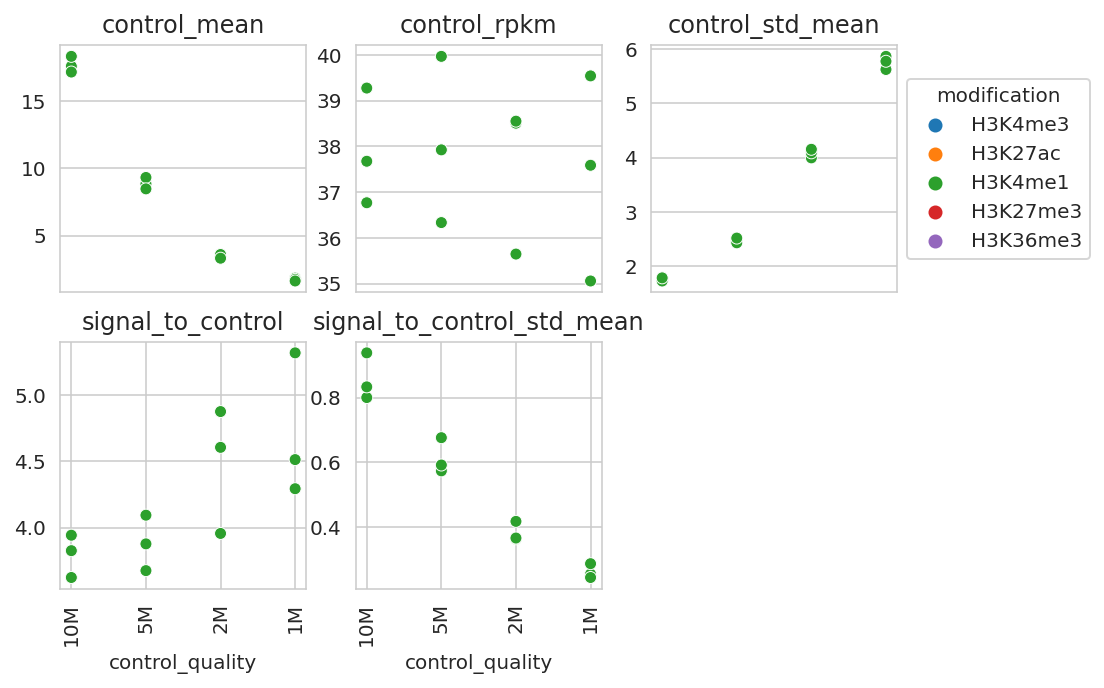

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

In [254]:
features = ['control_mean', 'control_rpkm', 'control_std_mean', 'signal_to_control', 'signal_to_control_std_mean']
ncols = int(math.ceil(math.sqrt(len(features) + 3)))
nrows = int(math.ceil(len(features) / ncols))
plt.figure(figsize=(2.5 * ncols, 2.5 * nrows))
axs = [plt.subplot(nrows, ncols, i + 1) for i in range(len(features))]
tt = df_bw_stats_signal_aggr[(df_bw_stats_signal_aggr['modification'] == m)].copy()
tt['control_quality_i'] = 0
for i, mln in enumerate([20] + MLNS):
    tt.loc[tt['mln'] == mln, 'control_quality_i'] = i
for i, y in enumerate(features):
    ax = axs[i]
    plt.figure(figsize=(4, 3))
    sns.scatterplot(data=tt, x='control_quality_i', y=y, hue='modification',
                    hue_order=MODIFICATIONS,
                    ax=ax)
    ax.set_xticklabels([f'{mln}M' for mln in [20] + MLNS])
    ax.set_xlabel('control_quality')
    ax.title.set_text(y)
    ax.set_ylabel(None)
    if i / ncols < nrows - 1:
        ax.set_xlabel(None)
        ax.set_xticks([], minor=False)
        ax.set_xticklabels([])
    ax.xaxis.set_tick_params(rotation=90)
    if i % ncols == ncols - 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

# Analyze vs peaks number

In [244]:
df_aggr = pd.merge(df_bw_stats_signal_aggr,
                   df_immune_mln_controls,
                   on=['dataset', 'modification', 'cell', 'replicate', 'mln'], how='inner')
df_aggr[['dataset', 'modification', 'cell', 'replicate', 'mln']].drop_duplicates().groupby(['dataset', 'modification']).size()

dataset  modification
Roadmap  H3K4me1         12
dtype: int64

Full


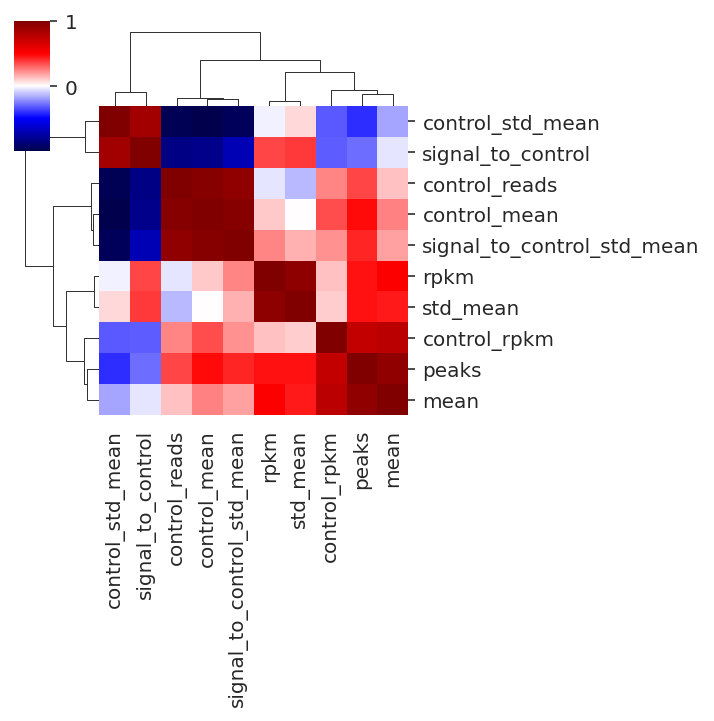

<Figure size 504x216 with 0 Axes>

<Figure size 504x216 with 0 Axes>

In [255]:
TOOL = 'SPAN'
tt = df_aggr[(df_aggr['modification'] == 'H3K4me1') & (df_aggr['tool'] == TOOL)]
features = ['peaks', 
            'mean', 'rpkm', 'std_mean',
            'control_reads', 'control_mean', 'control_rpkm', 'control_std_mean',
             'signal_to_control', 'signal_to_control_std_mean']
print('Full')
sns.clustermap(tt[features].corr(method='spearman'),
               col_cluster=True, row_cluster=True,
               figsize=(5, 5),
               cmap=plt.cm.seismic)
plt.show()
plt.figure(figsize=(7, 3))

H3K4me1 SPAN


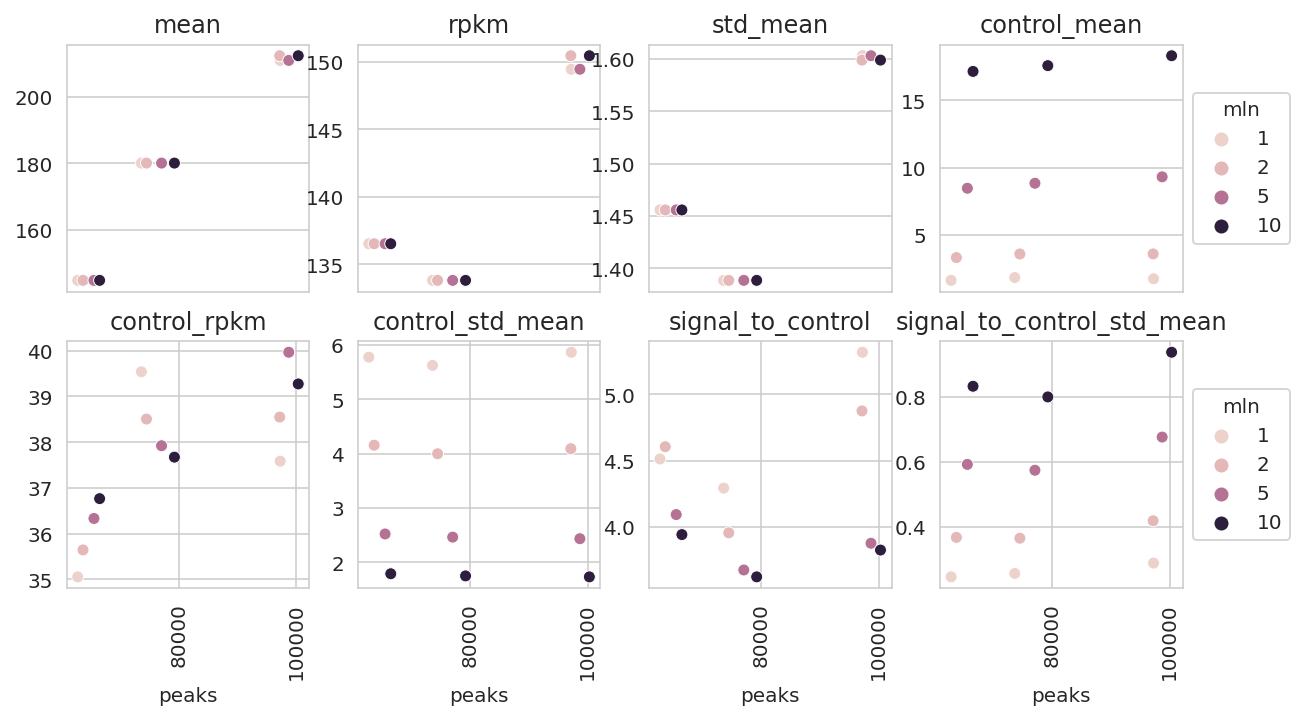

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

In [256]:
features = ['mean', 'rpkm', 'std_mean',
            'control_mean', 'control_rpkm', 'control_std_mean', 
            'signal_to_control', 'signal_to_control_std_mean']
ncols = int(math.ceil(math.sqrt(len(features) + 3)))
nrows = int(math.ceil(len(features) / ncols))
# for m in MODIFICATIONS:
for m in ['H3K4me1']:
    print(m, TOOL)
    plt.figure(figsize=(2.5 * ncols, 2.5 * nrows))
    axs = [plt.subplot(nrows, ncols, i + 1) for i in range(len(features))]
    tt = df_aggr[(df_aggr['modification'] == m) & (df_aggr['tool'] == TOOL)]
    for i, y in enumerate(features):
        ax = axs[i]
        plt.figure(figsize=(4, 3))
        sns.scatterplot(data=tt, x='peaks', y=y, hue='mln', 
                    hue_order=[20, 10, 5, 2, 1],
                    ax=ax)
        ax.title.set_text(y)
        ax.set_ylabel(None)
        if i / ncols < nrows - 1:
            ax.set_xlabel(None)
            ax.set_xticks([], minor=False)
            ax.set_xticklabels([])
        ax.xaxis.set_tick_params(rotation=90)
        if i % ncols == ncols - 1:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            ax.legend().set_visible(False)

    plt.tight_layout()
    plt.show()

# Recompute MACS2 with --scale-to=large option

```
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory `pwd` --config genome=hg38 fastq_dir=`pwd` start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" macs2=True macs2_params="--scale-to=large --q=0.05" macs2_suffix="q0.05_large" --rerun-trigger mtime --rerun-incomplete;
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory `pwd` --config genome=hg38 fastq_dir=`pwd` start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1 --scale-to=large" macs2_suffix="broad0.1_large"  --rerun-trigger mtime; 
mkdir macs2_large
mv macs2/*large* macs2_large/
```

In [369]:
t1 = load_peaks(os.path.join(GSE26320_PATH, 'macs2_large'), '.narrowPeak', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
t1['tool'] = 'MACS2'
t2 = load_peaks(os.path.join(GSE26320_PATH, 'macs2_large'), '.broadPeak', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
t2['tool'] = 'MACS2 broad'
df_macs2_large = pd.concat([t1, t2]).reset_index(drop=True)
df_macs2_large['dataset'] = 'ENCODE'
print('MACS2', len(df_macs2_large))

  0%|          | 0/680 [00:00<?, ?it/s]

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 170


In [370]:
df_peaks_macs2_large = pd.concat([df_macs2_large, df_peaks[(df_peaks['dataset'] == 'ENCODE') & 
                                                          (df_peaks['control'] == True) & 
                                                          (df_peaks['tool'].isin(['SPAN', 'SICER']))]]).reset_index(drop=True)
df_peaks_macs2_large.sample(5)

file modification     cell  \
103  /home/jetbrains/data/2023_GSE26320/macs2_large...     H3K36me3  GM12878   
323  /home/jetbrains/data/2023_GSE26320/span/GSM646...     H3K27me3     NHLF   
225  /home/jetbrains/data/2023_GSE26320/sicer/GSM64...     H3K36me3     NHEK   
96   /home/jetbrains/data/2023_GSE26320/macs2_large...     H3K27me3     HMEC   
161  /home/jetbrains/data/2023_GSE26320/macs2_large...      H3K4me3     NHEK   

    replicate  peaks         tool dataset control  
103      rep1  83252  MACS2 broad  ENCODE     NaN  
323      rep1  23889         SPAN  ENCODE    True  
225      rep2  46199        SICER  ENCODE    True  
96       rep2  48186  MACS2 broad  ENCODE     NaN  
161      rep1  42362  MACS2 broad  ENCODE     NaN

In [373]:
# Remove outliers, see 2023 - figures.ipynb
OUTLIERS = [('H3K4me3', 'NK', ''),
            ('H3K4me1', 'NK', ''),
            ('H3K27me3', 'TCell', ''),
            ('H3K27me3', 'NHLF', 'rep2'),
            ('H3K27me3', 'GM12878', 'rep1')]

df_peaks_macs2_large = df_peaks_macs2_large.loc[[(m, c, r) not in OUTLIERS
                         for _, (m, c, r) in df_peaks_macs2_large[['modification', 'cell', 'replicate']].iterrows()]].copy()
df_peaks_macs2_large.sample(3)

file modification   cell  \
64   /home/jetbrains/data/2023_GSE26320/macs2_large...      H3K4me1   K562   
232  /home/jetbrains/data/2023_GSE26320/sicer/GSM64...      H3K4me3   HSMM   
11   /home/jetbrains/data/2023_GSE26320/macs2_large...      H3K27ac  HepG2   

    replicate  peaks   tool dataset control  
64       rep2  79415  MACS2  ENCODE     NaN  
232      rep2  23763  SICER  ENCODE    True  
11       rep2  49388  MACS2  ENCODE     NaN

/tmp/ipykernel_522188/2417727036.py:11: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df_peaks_macs2_large[df_peaks_macs2_large['modification'] == m], x='tool', y='peaks',
/tmp/ipykernel_522188/2417727036.py:11: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df_peaks_macs2_large[df_peaks_macs2_large['modification'] == m], x='tool', y='peaks',
/tmp/ipykernel_522188/2417727036.py:11: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df_peaks_macs2_large[df_peaks_macs2_large['modification'] == m], x='tool', y='peaks',
/tmp/ipykernel_522188/2417727036.py:11: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df_peaks_macs2_large[df_peaks_macs2_large['modification'] == m], x='tool', y='peaks',
/tmp/ipykernel_522188/2417727036.py:11: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmp

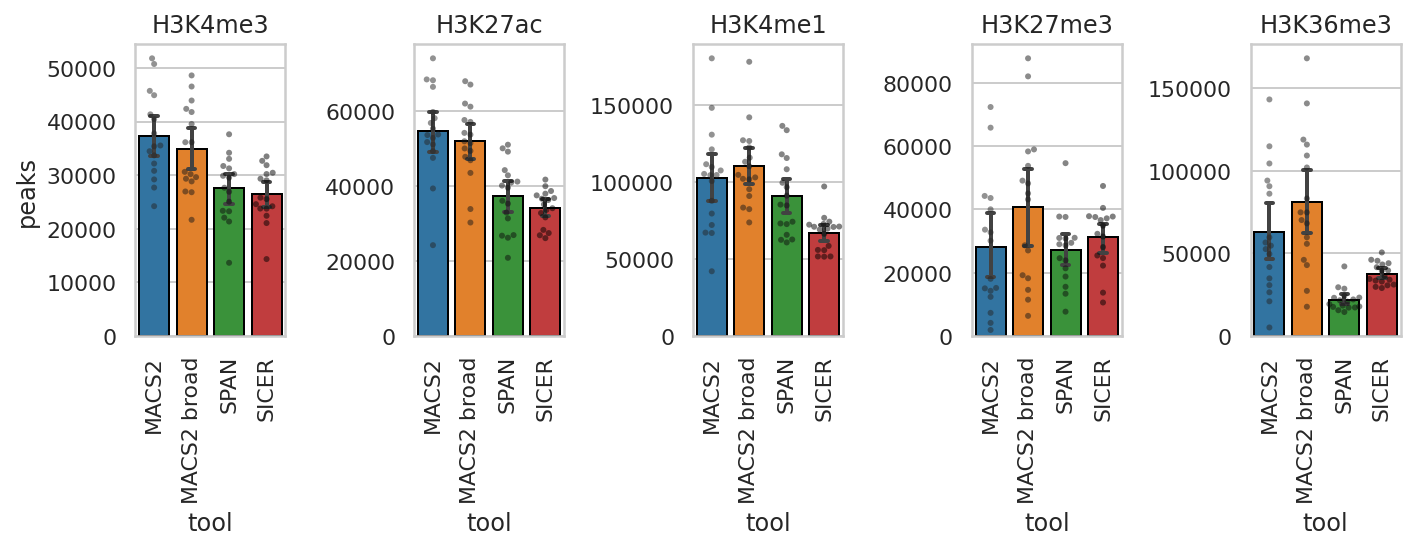

In [374]:
plt.figure(figsize=(10, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.barplot(data=df_peaks_macs2_large[df_peaks_macs2_large['modification'] == m], x='tool', y='peaks',
                # showfliers=False,
                capsize=.2, errwidth=2, edgecolor="black",
                palette=TOOLS_PALETTE,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                ax=ax)
    sns.swarmplot(data=df_peaks_macs2_large[df_peaks_macs2_large['modification'] == m], x='tool', y='peaks',
                  size=3, palette='dark:black', alpha=0.5,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    # ax.set_ylim(0, 1)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Compare replicates

In [375]:
df_macs2_large_reps = compute_reps_peaks(df_peaks_macs2_large, MODIFICATIONS, GSE26320_CELLS)
df_macs2_large_reps['reps_peaks_diff'] = np.fabs((df_macs2_large_reps['peaks1'] - df_macs2_large_reps['peaks2']) /
                                                 (df_macs2_large_reps['peaks1'] + df_macs2_large_reps['peaks2']))
df_macs2_large_reps.sample(5)

dataset modification     cell         tool replicate1 replicate2  peaks1  \
119  ENCODE      H3K4me1     NHEK         SPAN       rep1       rep2  108123   
13   ENCODE      H3K27ac    HepG2  MACS2 broad       rep1       rep2   43581   
51   ENCODE     H3K27me3    Huvec         SPAN       rep1       rep2   30792   
136  ENCODE      H3K4me3     HSMM        MACS2       rep1       rep2   27688   
94   ENCODE      H3K4me1  GM12878        SICER       rep1       rep2   70985   

     peaks2  reps_peaks_diff  
119  117793         0.042804  
13    51542         0.083692  
51    54573         0.278580  
136   32169         0.074862  
94    51620         0.157946

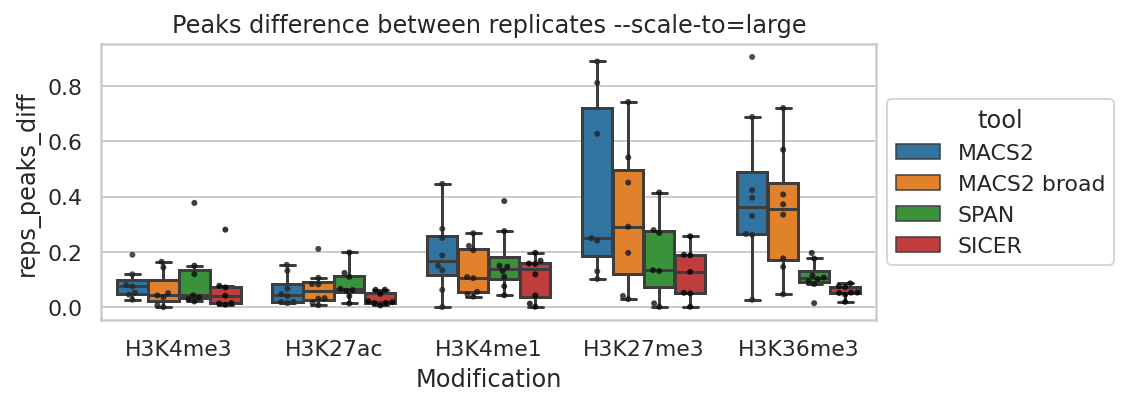

In [379]:
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=df_macs2_large_reps, x='modification', hue='tool', y='reps_peaks_diff',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=df_macs2_large_reps, x='modification', hue='tool', y='reps_peaks_diff',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.set_title('Peaks difference between replicates --scale-to=large')
# ax.set_ylabel('Peaks difference')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [377]:
t = pd.merge(df_controls, df_peaks_macs2_large[['dataset', 'modification', 'cell', 'replicate', 'tool', 'peaks']],
             left_on=['dataset', 'modification', 'cell', 'replicate1'],
             right_on=['dataset', 'modification', 'cell', 'replicate']
             )
t.rename({'peaks': 'rep1_peaks'}, axis=1, inplace=True)
t.drop('replicate', axis=1, inplace=True)
t = pd.merge(t, df_peaks_macs2_large[['dataset', 'modification', 'cell', 'replicate', 'tool', 'peaks']],
             left_on=['dataset', 'modification', 'cell', 'tool', 'replicate2'],
             right_on=['dataset', 'modification', 'cell', 'tool', 'replicate']
             )
t.rename({'peaks': 'rep2_peaks'}, axis=1, inplace=True)
t.drop('replicate', axis=1, inplace=True)
t = pd.merge(t, df_bams[['dataset', 'modification', 'cell', 'replicate', 'reads']],
             left_on=['dataset', 'modification', 'cell', 'replicate1'],
             right_on=['dataset', 'modification', 'cell', 'replicate']
             )
t.rename({'reads': 'rep1_reads'}, axis=1, inplace=True)
t.drop('replicate', axis=1, inplace=True)
t = pd.merge(t, df_bams[['dataset', 'modification', 'cell', 'replicate', 'reads']],
             left_on=['dataset', 'modification', 'cell', 'replicate2'],
             right_on=['dataset', 'modification', 'cell', 'replicate']
             )
t.rename({'reads': 'rep2_reads'}, axis=1, inplace=True)
t.drop('replicate', axis=1, inplace=True)
t = pd.merge(t, df_bams[df_bams['modification'] == 'Control'][['dataset', 'cell', 'replicate', 'reads']],
             left_on=['dataset', 'cell', 'control_replicate1'],
             right_on=['dataset', 'cell', 'replicate']
             )
t.rename({'reads': 'rep1_ctrl_reads'}, axis=1, inplace=True)
t.drop('replicate', axis=1, inplace=True)
t = pd.merge(t, df_bams[df_bams['modification'] == 'Control'][['dataset', 'cell', 'replicate', 'reads']],
             left_on=['dataset', 'cell', 'control_replicate2'],
             right_on=['dataset', 'cell', 'replicate']
             )
t.rename({'reads': 'rep2_ctrl_reads'}, axis=1, inplace=True)
t.drop('replicate', axis=1, inplace=True)

t.head(5)

dataset modification     cell replicate1  \
0  ENCODE      H3K27ac  GM12878       rep2   
1  ENCODE      H3K27ac  GM12878       rep2   
2  ENCODE      H3K27ac  GM12878       rep2   
3  ENCODE      H3K27ac  GM12878       rep2   
4  ENCODE      H3K27ac     HMEC       rep1   

                                               file1 control_replicate1  \
0  /home/jetbrains/data/2023_GSE26320/bams/GSM646...               rep2   
1  /home/jetbrains/data/2023_GSE26320/bams/GSM646...               rep2   
2  /home/jetbrains/data/2023_GSE26320/bams/GSM646...               rep2   
3  /home/jetbrains/data/2023_GSE26320/bams/GSM646...               rep2   
4  /home/jetbrains/data/2023_GSE26320/bams/GSM646...               rep1   

                                       control_file1 replicate2  \
0  /home/jetbrains/data/2023_GSE26320/bams/GSM646...       rep1   
1  /home/jetbrains/data/2023_GSE26320/bams/GSM646...       rep1   
2  /home/jetbrains/data/2023_GSE26320/bams/GSM646...       rep1   
3  /home/jetbrains/data/2023_GSE26320/bams/GSM646...       rep1   
4  /home/jetbrains/data/2023_GSE26320/bams/GSM646...       rep2   

                                               file2 control_replicate2  \
0  /home/jetbrains/data/2023_GSE26320/bams/GSM646...               rep1   
1  /home/jetbrains/data/2023_GSE26320/bams/GSM646...               rep1   
2  /home/jetbrains/data/2023_GSE26320/bams/GSM646...               rep1   
3  /home/jetbrains/data/2023_GSE26320/bams/GSM646...               rep1   
4  /home/jetbrains/data/2023_GSE26320/bams/GSM646...               rep2   

                                       control_file2         tool  rep1_peaks  \
0  /home/jetbrains/data/2023_GSE26320/bams/GSM646...        MACS2       51192   
1  /home/jetbrains/data/2023_GSE26320/bams/GSM646...  MACS2 broad       46968   
2  /home/jetbrains/data/2023_GSE26320/bams/GSM646...        SICER       31704   
3  /home/jetbrains/data/2023_GSE26320/bams/GSM646...         SPAN       31429   
4  /home/jetbrains/data/2023_GSE26320/bams/GSM646...        MACS2       68322   

   rep2_peaks  rep1_reads  rep2_reads  rep1_ctrl_reads  rep2_ctrl_reads  
0       55415     5783112     7049058          5469340          5699825  
1       50110     5783112     7049058          5469340          5699825  
2       32861     5783112     7049058          5469340          5699825  
3       35376     5783112     7049058          5469340          5699825  
4       59851    10940745     9860687          3750119         10342115

MACS2 large


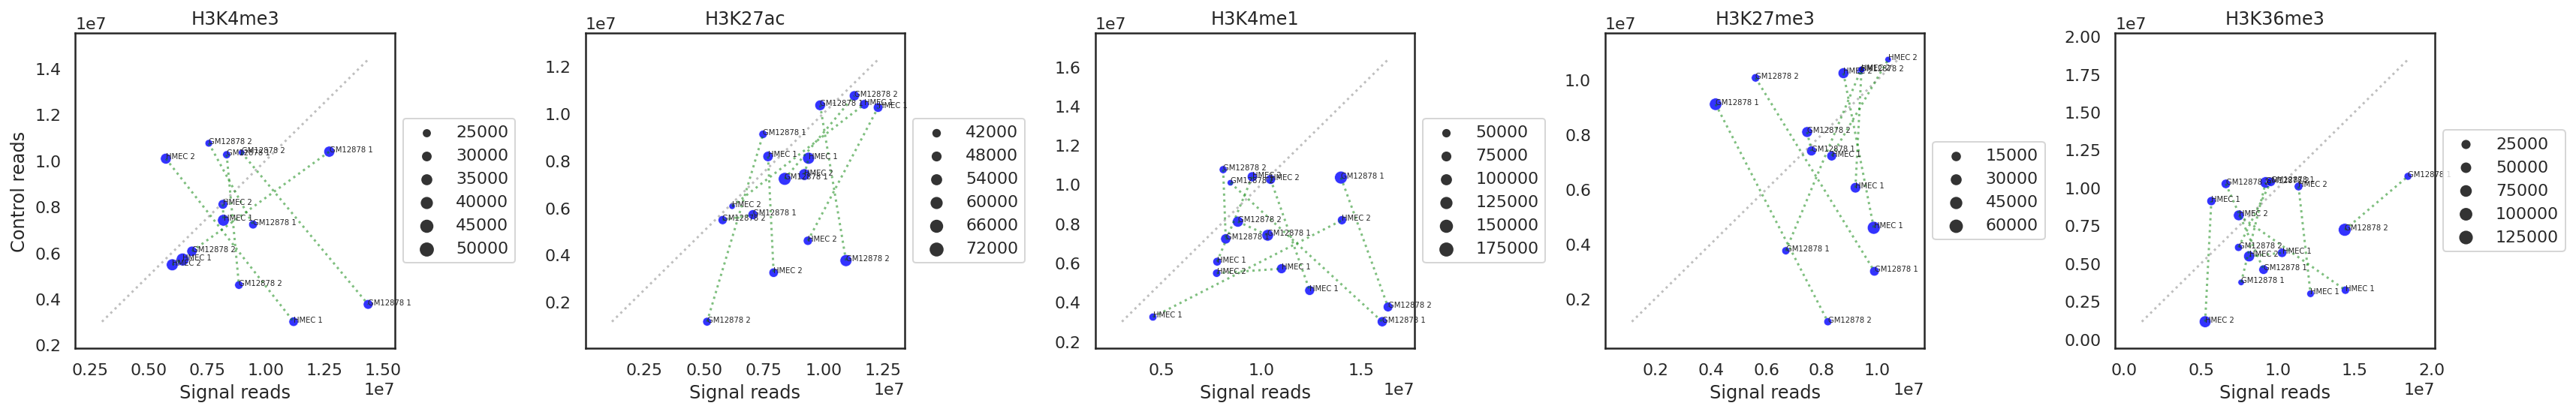

MACS2 broad large


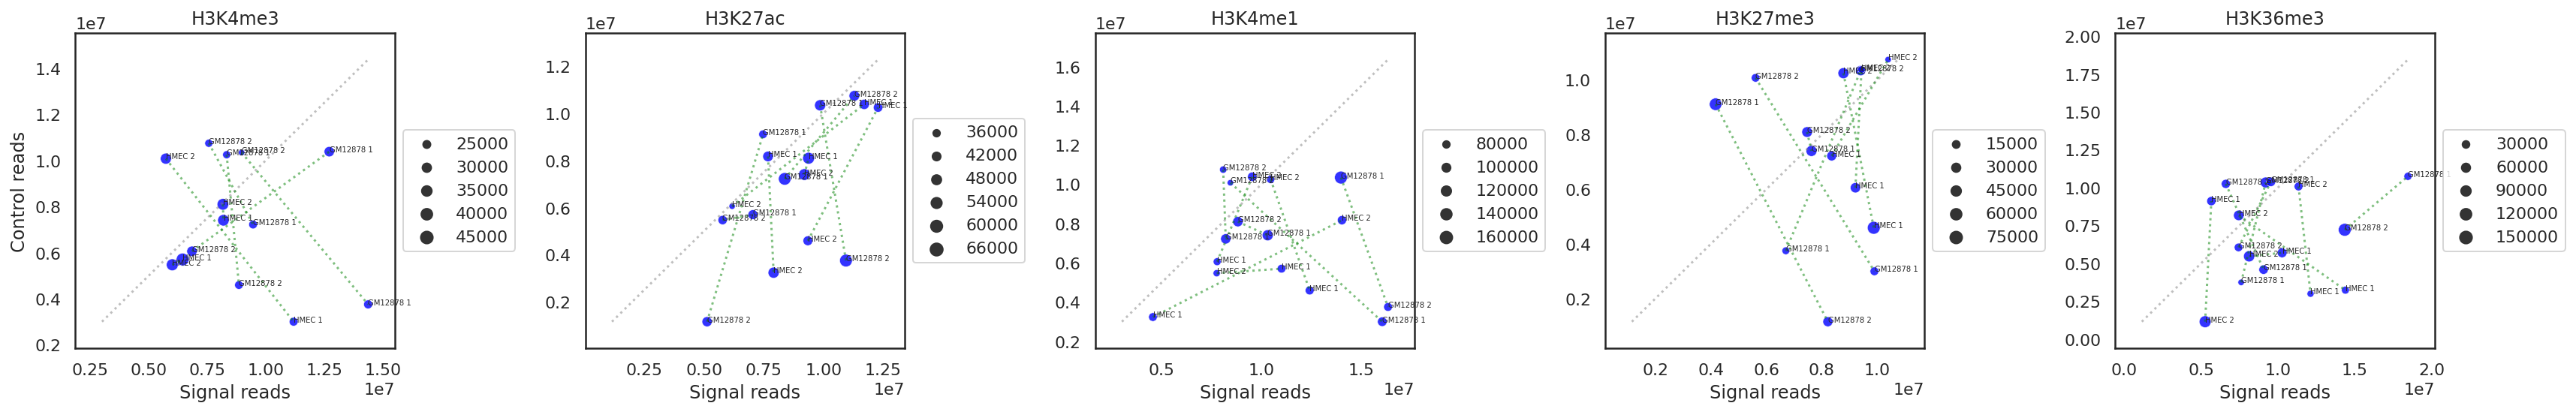

In [378]:
sns.set_theme(style='white')
for tool in ['MACS2', 'MACS2 broad']:
    print(tool, 'large')
    plt.figure(figsize=(24, 4))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        ax.set_title(m)
        tt = t[(t['dataset'] == 'ENCODE') & (t['modification'] == m) & (t['tool'] == tool)]
        rep1_peaks, rep1_reads, rep1_ctrl_reads = tt['rep1_peaks'], tt['rep1_reads'], tt['rep1_ctrl_reads']
        rep2_peaks, rep2_reads, rep2_ctrl_reads = tt['rep2_peaks'], tt['rep2_reads'], tt['rep2_ctrl_reads']
        minx = min(np.min(rep1_reads), np.min(rep2_reads))
        maxx = max(np.max(rep1_reads), np.max(rep2_reads))
        miny = min(np.min(rep1_ctrl_reads), np.min(rep2_ctrl_reads))
        maxy = max(np.max(rep1_ctrl_reads), np.max(rep2_ctrl_reads))
        minxy = min(minx, miny)
        maxxy = max(maxx, maxy)
        sns.lineplot(x=[minxy, maxxy], y=[minxy, maxxy], color='grey', ax=ax, alpha=0.5, linestyle='dotted')
        sns.scatterplot(x=rep1_reads.to_list() + rep2_reads.to_list(),
                        y=rep1_ctrl_reads.to_list() + rep2_ctrl_reads.to_list(),
                        alpha=0.8, ax = ax,
                        size=rep1_peaks.to_list() + rep2_peaks.to_list(),
                        color='blue')
        for r1r, r1cr, r2r, r2cr in zip(rep1_reads, rep1_ctrl_reads, rep2_reads, rep2_ctrl_reads):
            sns.lineplot(x=[r1r, r2r], y=[r1cr, r2cr], color='green', ax=ax, alpha=0.5, linestyle='dotted')
        for xv, yv, cell, rep in zip(rep1_reads, rep1_ctrl_reads, t['cell'], t['replicate1']):
            rep = '1' if rep == 'rep1' else '2' if rep == 'rep2' else ''
            ax.text(xv, yv, f'{cell} {rep}', fontsize = 5)
        for xv, yv, cell, rep in zip(rep2_reads, rep2_ctrl_reads, t['cell'], t['replicate2']):
            rep = '1' if rep == 'rep1' else '2' if rep == 'rep2' else ''
            ax.text(xv, yv, f'{cell} {rep}', fontsize = 5)
        offset = 0.1 * (maxxy - minxy)
        ax.set_xlabel('Signal reads')
        ax.set_ylabel('Control reads')
        ax.set_xlim(minxy - offset, maxxy + offset)
        ax.set_ylim(minxy - offset, maxxy + offset)
        if i > 0:
            ax.set_ylabel(None)
        # if i < len(axs) - 1:
        #     ax.legend().set_visible(False)
        # else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()
sns.set_theme(style='whitegrid')